In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import os
import sys
import json
import pickle
import copy
from matplotlib import pyplot as plt
import matplotlib.patheffects as path_effects
from scipy.stats import ttest_ind, pearsonr
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage
import scipy.cluster.hierarchy as hierarchy
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import cross_validate, KFold, GridSearchCV, RandomizedSearchCV
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import f1_score, accuracy_score

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)
size = lambda obj: '%s MB' % np.round(sys.getsizeof(obj) / (1024**2), 1)

In [6]:
sys.path.append('..')

In [8]:
from acda.method_functions import *
from acda.plot_functions import *
from acda.general_functions import *

ModuleNotFoundError: No module named 'acda'

In [5]:
from preparation_functions import *
from additional_plotting_functions import *

In [9]:
projectDir = 'c:/Projects/A_PDX_drug_synergy/'
dirAZpharmacol = projectDir + 'data/restricted_use/syn18496666/AZ Drug Synergy Data/'
dirAZmolecular = projectDir + 'data/restricted_use/syn4923181/'
dirGDSCsensitivity = projectDir + 'data/fromGDSC/'
dirGraceCuratedSynergy = projectDir + 'data/curated synergy Grace/'
dirFromSanger = projectDir + 'data/fromSanger/' # https://cellmodelpassports.sanger.ac.uk/downloads

# Sensitivity

In [10]:
#               LNIC50         H       EINF
# MODEL DRUG                               
# 22RV1 AKT  -1.128191  4.117612  65.593002
#       AR    0.551742  0.234400  88.396987
#       AR_1  1.544170  2.815893  42.790641

In [11]:
df_drug_sensitivity_AZ = prepAZsensitivity(dirAZpharmacol + 'Combined Challenge Synergy Data/')
print(df_drug_sensitivity_AZ.shape)

(4861, 3)


In [12]:
df_drug_sensitivity_GDSC1 = prepGDSC('GDSC1', dirGDSCsensitivity)
print(df_drug_sensitivity_GDSC1.shape)

(292849, 2)


In [13]:
df_drug_sensitivity_GDSC2 = prepGDSC('GDSC2', dirGDSCsensitivity)
print(df_drug_sensitivity_GDSC2.shape)

(131108, 2)


In [14]:
df_drug_sensitivity_GDSC = pd.concat([df_drug_sensitivity_GDSC1, df_drug_sensitivity_GDSC2], axis=0).groupby(level=[0, 1]).mean()
print(df_drug_sensitivity_GDSC.shape)

(376632, 2)


# Synergy

In [15]:
# MODEL  DRUG1  DRUG2
# 22RV1  akt    ar        0.190
#               ar_1      6.415
#               bcl2    -54.700

In [16]:
# 119 drugs * 137 models = 19623 unique pairs
se_drug_synergy_AZ = prepAZsynergy(dirAZpharmacol + 'Combined Challenge Synergy Data/')
print(se_drug_synergy_AZ.shape)

(39246,)


In [17]:
# 240 drugs * 109 models = 437 unique pairs
se_drug_synergy_Narayan = prepNarayanSynergy(dirGraceCuratedSynergy + 'edited_41467_2020_16735_MOESM5_ESM.xlsx')
print(se_drug_synergy_Narayan.shape)

(874,)


# DREAM challenge index

In [18]:
se_AZchallengeIndex = loadAZchallengeIndex(se_drug_synergy_AZ, dirAZpharmacol)

4273 c:/Projects/A_PDX_drug_synergy/data/restricted_use/syn18496666/AZ Drug Synergy Data/ch1_train_combination_and_monotherapy.csv
2178 c:/Projects/A_PDX_drug_synergy/data/restricted_use/syn18496666/AZ Drug Synergy Data/ch1_test_monotherapy.csv
1182 c:/Projects/A_PDX_drug_synergy/data/restricted_use/syn18496666/AZ Drug Synergy Data/ch1_lb.csv
7643 c:/Projects/A_PDX_drug_synergy/data/restricted_use/syn18496666/AZ Drug Synergy Data/ch2_test_monotherapy.csv
7740 c:/Projects/A_PDX_drug_synergy/data/restricted_use/syn18496666/AZ Drug Synergy Data/ch2_lb.csv
22634
ch2_leaderboard    7556
ch2_test           7534
ch1_train          4224
ch1_test           2154
ch1_leaderboard    1166
Name: SYNERGY_SCORE, dtype: int64


In [19]:
# Test ro
subset = se_drug_synergy_AZ.iloc[:10000].to_frame()
subset['SYNERGY_SCORE_PREDICTED'] = np.random.rand(len(subset))
print(ro_normalized(subset))

0.0008166743885908147


# Tissue annotation

In [20]:
# MODEL
# 1181N1     Central Nervous System
# 1205Lu                       Skin
# 1273-99               Soft Tissue

In [21]:
se_tissue_annotation_AZ = getTissueAnnotationAZ(dirAZmolecular + 'cell_info.csv.gz')
print(se_tissue_annotation_AZ.value_counts().to_dict())
print(se_tissue_annotation_AZ.shape)

{'breast': 34, 'lung': 22, 'urinary tract': 12, 'gastrointestinal tract (lower)': 10, 'male genital system': 2, 'soft tissue': 2, 'gastrointestinal tract (upper)': 2, 'blood/lymph': 1}
(85,)


In [22]:
se_tissue_annotation_GDSC = getTissueAnnotationGDSC(dirFromSanger + 'model_list_20210719.csv')
print(se_tissue_annotation_GDSC.value_counts().to_dict())
print(se_tissue_annotation_GDSC.shape)

{'Haematopoietic and Lymphoid': 370, 'Lung': 293, 'Skin': 131, 'Large Intestine': 123, 'Central Nervous System': 118, 'Head and Neck': 95, 'Ovary': 85, 'Bone': 82, 'Breast': 82, 'Pancreas': 74, 'Esophagus': 74, 'Soft Tissue': 73, 'Kidney': 63, 'Peripheral Nervous System': 48, 'Stomach': 46, 'Bladder': 40, 'Biliary Tract': 39, 'Cervix': 32, 'Endometrium': 30, 'Liver': 29, 'Thyroid': 21, 'Prostate': 15, 'Eye': 11, 'Uterus': 8, 'Unknown': 7, 'Testis': 5, 'Placenta': 4, 'Vulva': 3, 'Small Intestine': 2, 'Adrenal Gland': 1}
(2004,)


# Models mutations

In [23]:
# MODEL
# 22RV1    [A1CF, A1CF_ENST00000282641, A1CF_ENST00000373...
# 647-V    [A2ML1, AASDH, AASDH_ENST00000502617, AASS, AB...
# A549     [AATK, AATK_ENST00000326724, ABCA9, ABCB1, ABC...

In [24]:
se_models_mutations_AZ = prepMutationsAZ(dirAZmolecular + 'mutations.csv.gz')
print(se_models_mutations_AZ.shape)

(85,)


In [25]:
se_models_mutations_GDSC = prepMutationsGDSC(dirFromSanger + 'mutations_20191101.csv')
print(se_models_mutations_GDSC.shape)

(1032,)


# Drug targets

In [26]:
# DRUG
# (5Z)-7-Oxozeaenol                        [MAP3K7]
# 5-Fluorouracil       [Antimetabolite (DNA & RNA)]
# A-443654                       [AKT1, AKT2, AKT3]

In [27]:
se_drug_targets_GDSC = prepDrugTargetsGDSC(dirGraceCuratedSynergy + 'screened_compunds_updated.xlsx')  # 442 drugs
print(se_drug_targets_GDSC.apply(len).value_counts().sort_index().to_dict())
print(se_drug_targets_GDSC.shape)

{1: 245, 2: 91, 3: 48, 4: 16, 5: 9, 6: 5, 7: 8, 8: 3, 9: 1, 10: 2, 11: 5, 12: 2, 14: 1, 16: 1, 18: 2, 23: 1, 31: 1, 39: 1}
(442,)


In [28]:
print(se_drug_targets_GDSC)

DRUG
(5Z)-7-Oxozeaenol                                                     [MAP3K7]
5-Fluorouracil                                    [Antimetabolite (DNA & RNA)]
A-443654                                                    [AKT1, AKT2, AKT3]
A-770041                                                            [LCK, FYN]
A-83-01                                                                [TGFB1]
                                                   ...                        
Zibotentan                                                             [EDNRA]
Zoledronate                                                      [FDPS, GGPS1]
eEF2K Inhibitor, A-484954                                              [EEF2K]
kb NB 142-70                                                           [PRKD1]
rTRAIL                       [TNFRSF10A, TNFRSF10B, TNFRSF10C, TNFRSF10D, T...
Name: TARGETS, Length: 442, dtype: object


In [29]:
se_drug_targets_AZ = prepDrugTargetsAZ(dirAZpharmacol + 'drug_info_release.csv.gz', dirFromSanger + 'gene_identifiers_20191101.csv')
print(se_drug_targets_AZ.apply(len).value_counts().sort_index().to_dict())
print(se_drug_targets_AZ.shape)

{1: 68, 2: 19, 3: 13, 4: 6, 5: 1, 6: 1, 7: 2, 8: 3, 9: 2, 12: 2, 15: 1, 21: 1}
(119,)


# Prepare values for regression or classifier

In [30]:
# all_models = se_drug_synergy_AZ.reset_index()['MODEL']
# all_models[~all_models.isin(se_tissue_annotation_AZ.index)] = 'NA'
# all_models[all_models.isin(se_tissue_annotation_AZ.index)] = se_tissue_annotation_AZ.loc[all_models[all_models.isin(se_tissue_annotation_AZ.index)].values].values
# print(all_models.value_counts().to_dict())

In [31]:
# dfTas_GDSC1_breast = makeCDAformattedData('Breast', se_drug_synergy_Narayan, se_tissue_annotation_GDSC, df_drug_sensitivity_GDSC1, se_models_mutations_GDSC, se_drug_targets_GDSC, 1., 'GDSC1')
# dfTas_GDSC1_bladder = makeCDAformattedData('Bladder', se_drug_synergy_Narayan, se_tissue_annotation_GDSC, df_drug_sensitivity_GDSC1, se_models_mutations_GDSC, se_drug_targets_GDSC, 1., 'GDSC1')
# dfTas_GDSC2_breast = makeCDAformattedData('Breast', se_drug_synergy_Narayan, se_tissue_annotation_GDSC, df_drug_sensitivity_GDSC2, se_models_mutations_GDSC, se_drug_targets_GDSC, 1., 'GDSC2')
# dfTas_GDSC2_bladder = makeCDAformattedData('Bladder', se_drug_synergy_Narayan, se_tissue_annotation_GDSC, df_drug_sensitivity_GDSC2, se_models_mutations_GDSC, se_drug_targets_GDSC, 1., 'GDSC2')
# dfTas_GDSC_breast = makeCDAformattedData('Breast', se_drug_synergy_Narayan, se_tissue_annotation_GDSC, df_drug_sensitivity_GDSC, se_models_mutations_GDSC, se_drug_targets_GDSC, 1., 'GDSC')
# dfTas_GDSC_bladder = makeCDAformattedData('Bladder', se_drug_synergy_Narayan, se_tissue_annotation_GDSC, df_drug_sensitivity_GDSC, se_models_mutations_GDSC, se_drug_targets_GDSC, 1., 'GDSC')

### Regression model per tissue
Learn about synergy for the different drug pairs in different cell lines of a selected tissue.<br>
Transter this knowledge to predict synergy for a new cell line and another drug pair (of the same tissue!).<br>
$logit(\Theta_{ijk}) = a_1 + a_2*T_{ijk} + a_3*C_{ij} + a_4*S_{ik} + a_5*S_{jk}$<br>
<br>
Need to explore goodness of fit (Chi-square goodness of fit tests and deviance) with and without some of the terms.
As compared to random?

Cell line tissue: seTissues <br>
Target information: dfTa_k(ij) = dfT_ki | dfT_kj <br>
Cophenetic distance: dfC_ij <br>
Sensitivity to drug i: dfS_ki <br>
Sensitivity to drug j: dfS_kj <br>
Known synergy between drugs i and j: dfKS_(ij)

In [31]:
# df_train_test_ch1, df_validate_ch1 = prepareSubChallenge1(dfTas_AZ_breast, se_AZchallengeIndex[se_AZchallengeIndex=='ch1_train'].index, se_AZchallengeIndex[se_AZchallengeIndex=='ch1_test'].index)
# features = df_train_test_ch1.columns[~df_train_test_ch1.columns.isin(['SYNERGY_SCORE', 'Tijk', 'Cij', 'Sik', 'Sjk'])]
# df = pd.concat([df_validate_ch1[features], -df_train_test_ch1[features]], axis=0)
# from scipy.cluster.hierarchy import dendrogram, linkage
# import scipy.cluster.hierarchy as hierarchy
# from scipy.spatial.distance import pdist
# fig, ax = plt.subplots(figsize=(10,10))
# D1 = dendrogram(linkage(pdist(df.values.T, metric='euclidean'), method='ward', optimal_ordering=True), no_plot=True)['leaves']
# ax.imshow(df.sort_index().iloc[:, D1], cmap='Blues', aspect='auto', vmin=-1, vmax=1, interpolation='None')

# GDSC bladder

In [36]:
dfTas_GDSC1_bladder = makeCDAformattedData('Bladder', se_drug_synergy_Narayan, se_tissue_annotation_GDSC, df_drug_sensitivity_GDSC1, se_models_mutations_GDSC, se_drug_targets_GDSC, 1., 'GDSC1')
dfTas_GDSC2_bladder = makeCDAformattedData('Bladder', se_drug_synergy_Narayan, se_tissue_annotation_GDSC, df_drug_sensitivity_GDSC2, se_models_mutations_GDSC, se_drug_targets_GDSC, 1., 'GDSC2')
dfTas_GDSC_bladder = makeCDAformattedData('Bladder', se_drug_synergy_Narayan, se_tissue_annotation_GDSC, df_drug_sensitivity_GDSC, se_models_mutations_GDSC, se_drug_targets_GDSC, 1., 'GDSC')

Loading from cache...
979 cell lines, 117649 drug pairs
Synergy pairs in:	 874
Synergy pairs out:	 208
Data size: 115178371
0 1 2 3 4 5 6 7 8 9 10 11 
With known synergy: 38
With unknown synergy: 2235293
Loading from cache...
803 cell lines, 34969 drug pairs
Synergy pairs in:	 874
Synergy pairs out:	 134
Data size: 28080107
0 1 2 
With known synergy: 8
With unknown synergy: 629434
Loading from cache...
980 cell lines, 195364 drug pairs
Synergy pairs in:	 874
Synergy pairs out:	 258
Data size: 191456720
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
With known synergy: 40
With unknown synergy: 3711876


In [133]:
df_GDSC1_bladder = MonteCarloCrossValidation(dfTas_GDSC1_bladder, sample_non_synergy=True)
df_GDSC1_bladder[0]

0

All pairs:		 2235331
Pairs with missing:	 508781
All with known pairs:	 97
Training-testing pairs:	 64
Validation pairs:	 33
Prediction pairs:	 1726453

 M:
On self:		 0.99334
Validation data:	 0.917
ro normalized:		 nan

 ACDA:


C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



On self:		 0.96185
Validation data:	 0.657
ro normalized:		 nan

 CDA:
On self:		 0.64315
Validation data:	 0.499
ro normalized:		 nan

 EN-ACDA:


C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



On self:		 0.99163
Validation data:	 0.898
ro normalized:		 nan
1


C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars




All pairs:		 2235331
Pairs with missing:	 508781
All with known pairs:	 99
Training-testing pairs:	 66
Validation pairs:	 33
Prediction pairs:	 1726451

 M:
On self:		 0.9993
Validation data:	 0.998
ro normalized:		 nan

 ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



On self:		 0.93771
Validation data:	 0.694
ro normalized:		 nan

 CDA:
On self:		 0.58279
Validation data:	 0.708
ro normalized:		 nan

 EN-ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site

On self:		 0.99524
Validation data:	 0.99
ro normalized:		 nan
2


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars




All pairs:		 2235331
Pairs with missing:	 508781
All with known pairs:	 92
Training-testing pairs:	 61
Validation pairs:	 31
Prediction pairs:	 1726458

 M:
On self:		 0.99892
Validation data:	 0.878
ro normalized:		 nan

 ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



On self:		 0.95563
Validation data:	 0.783
ro normalized:		 nan

 CDA:
On self:		 0.64246
Validation data:	 0.693
ro normalized:		 nan

 EN-ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site

On self:		 0.99846
Validation data:	 0.891
ro normalized:		 nan
3


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars




All pairs:		 2235331
Pairs with missing:	 508781
All with known pairs:	 105
Training-testing pairs:	 70
Validation pairs:	 35
Prediction pairs:	 1726445

 M:
On self:		 0.99996
Validation data:	 1.0
ro normalized:		 nan

 ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



On self:		 0.97097
Validation data:	 0.413
ro normalized:		 nan

 CDA:
On self:		 0.62714
Validation data:	 0.503
ro normalized:		 nan

 EN-ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site

On self:		 0.99853
Validation data:	 0.995
ro normalized:		 nan
4


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars




All pairs:		 2235331
Pairs with missing:	 508781
All with known pairs:	 99
Training-testing pairs:	 66
Validation pairs:	 33
Prediction pairs:	 1726451

 M:
On self:		 0.99997
Validation data:	 1.0
ro normalized:		 nan

 ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



On self:		 0.97699
Validation data:	 0.698
ro normalized:		 nan

 CDA:
On self:		 0.72334
Validation data:	 0.608
ro normalized:		 nan

 EN-ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site

On self:		 0.99876
Validation data:	 0.994
ro normalized:		 nan
5


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars




All pairs:		 2235331
Pairs with missing:	 508781
All with known pairs:	 99
Training-testing pairs:	 66
Validation pairs:	 33
Prediction pairs:	 1726451

 M:
On self:		 0.99061
Validation data:	 0.999
ro normalized:		 nan

 ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



On self:		 0.957
Validation data:	 0.585
ro normalized:		 nan

 CDA:
On self:		 0.61019
Validation data:	 0.701
ro normalized:		 nan

 EN-ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site

On self:		 0.99005
Validation data:	 0.998
ro normalized:		 nan
6


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars




All pairs:		 2235331
Pairs with missing:	 508781
All with known pairs:	 105
Training-testing pairs:	 70
Validation pairs:	 35
Prediction pairs:	 1726445

 M:
On self:		 0.99278
Validation data:	 0.943
ro normalized:		 nan

 ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



On self:		 0.96793
Validation data:	 0.68
ro normalized:		 nan

 CDA:
On self:		 0.63545
Validation data:	 0.604
ro normalized:		 nan

 EN-ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site

On self:		 0.98965
Validation data:	 0.99
ro normalized:		 nan
7


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars




All pairs:		 2235331
Pairs with missing:	 508781
All with known pairs:	 98
Training-testing pairs:	 65
Validation pairs:	 33
Prediction pairs:	 1726452

 M:
On self:		 1.0
Validation data:	 0.449
ro normalized:		 nan

 ACDA:


C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



On self:		 0.968
Validation data:	 0.486
ro normalized:		 nan

 CDA:
On self:		 0.65876
Validation data:	 0.446
ro normalized:		 nan

 EN-ACDA:


C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



On self:		 0.99979
Validation data:	 0.474
ro normalized:		 nan
8


C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars




All pairs:		 2235331
Pairs with missing:	 508781
All with known pairs:	 89
Training-testing pairs:	 59
Validation pairs:	 30
Prediction pairs:	 1726461

 M:
On self:		 0.99397
Validation data:	 1.0
ro normalized:		 nan

 ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



On self:		 0.97395
Validation data:	 0.749
ro normalized:		 nan

 CDA:
On self:		 0.72455
Validation data:	 0.719
ro normalized:		 nan

 EN-ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site

On self:		 0.98935
Validation data:	 0.973
ro normalized:		 nan
9


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars




All pairs:		 2235331
Pairs with missing:	 508781
All with known pairs:	 90
Training-testing pairs:	 60
Validation pairs:	 30
Prediction pairs:	 1726460

 M:
On self:		 0.99269
Validation data:	 0.903
ro normalized:		 nan

 ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



On self:		 0.95906
Validation data:	 0.929
ro normalized:		 nan

 CDA:
On self:		 0.69092
Validation data:	 0.813
ro normalized:		 nan

 EN-ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site

On self:		 0.9906
Validation data:	 0.909
ro normalized:		 nan


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



,mean,sem
ACDA,0.667,0.047
CDA,0.629,0.037
EN,0.909,0.053
EN-ACDA,0.911,0.050


In [136]:
df_GDSC2_bladder = MonteCarloCrossValidation(dfTas_GDSC2_bladder, sample_non_synergy=True)
df_GDSC2_bladder[0]

0

All pairs:		 629442
Pairs with missing:	 147206
All with known pairs:	 82
Training-testing pairs:	 54
Validation pairs:	 28
Prediction pairs:	 482154

 M:
On self:		 0.82676
Validation data:	 0.328
ro normalized:		 nan

 ACDA:


C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



On self:		 0.93677
Validation data:	 0.557
ro normalized:		 nan

 CDA:
On self:		 0.35749
Validation data:	 0.373
ro normalized:		 nan

 EN-ACDA:


C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



On self:		 0.95904
Validation data:	 0.345
ro normalized:		 nan
1

All pairs:		 629442
Pairs with missing:	 147206
All with known pairs:	 85
Training-testing pairs:	 56


C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



Validation pairs:	 29
Prediction pairs:	 482151

 M:
On self:		 1.0
Validation data:	 nan
ro normalized:		 nan

 ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



On self:		 0.9369
Validation data:	 0.193
ro normalized:		 nan

 CDA:
On self:		 0.37439
Validation data:	 0.394
ro normalized:		 nan

 EN-ACDA:


C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



On self:		 0.99763
Validation data:	 0.207
ro normalized:		 nan
2

All pairs:		 629442
Pairs with missing:	 147206


C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



All with known pairs:	 84
Training-testing pairs:	 56
Validation pairs:	 28
Prediction pairs:	 482152

 M:
On self:		 0.86951
Validation data:	 0.675
ro normalized:		 nan

 ACDA:


C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



On self:		 0.93583
Validation data:	 0.652
ro normalized:		 nan

 CDA:
On self:		 0.4146
Validation data:	 0.304
ro normalized:		 nan

 EN-ACDA:


C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



On self:		 0.94261
Validation data:	 0.247
ro normalized:		 nan
3

All pairs:		 629442
Pairs with missing:	 147206
All with known pairs:	 84
Training-testing pairs:	 56
Validation pairs:	 28


C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



Prediction pairs:	 482152

 M:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



On self:		 nan
Validation data:	 nan
ro normalized:		 nan

 ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Proje

On self:		 nan
Validation data:	 nan
ro normalized:		 nan

 CDA:
On self:		 nan
Validation data:	 nan
ro normalized:		 nan

 EN-ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



On self:		 nan
Validation data:	 nan
ro normalized:		 nan
4

All pairs:		 629442
Pairs with missing:	 147206
All with known pairs:	 89
Training-testing pairs:	 59
Validation pairs:	 30
Prediction pairs:	 482147

 M:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



On self:		 nan
Validation data:	 nan
ro normalized:		 nan

 ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Proje

On self:		 nan
Validation data:	 nan
ro normalized:		 nan

 CDA:
On self:		 nan
Validation data:	 nan
ro normalized:		 nan

 EN-ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



On self:		 nan
Validation data:	 nan
ro normalized:		 nan
5

All pairs:		 629442
Pairs with missing:	 147206
All with known pairs:	 79
Training-testing pairs:	 52
Validation pairs:	 27
Prediction pairs:	 482157

 M:
On self:		 0.68337
Validation data:	 0.115
ro normalized:		 nan

 ACDA:


C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



On self:		 0.94826
Validation data:	 0.152
ro normalized:		 nan

 CDA:
On self:		 0.47063
Validation data:	 0.134
ro normalized:		 nan

 EN-ACDA:


C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



On self:		 0.94865
Validation data:	 0.122
ro normalized:		 nan
6


C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars




All pairs:		 629442
Pairs with missing:	 147206
All with known pairs:	 80
Training-testing pairs:	 53
Validation pairs:	 27
Prediction pairs:	 482156

 M:
On self:		 0.77784
Validation data:	 0.703
ro normalized:		 nan

 ACDA:


C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



On self:		 0.92116
Validation data:	 0.499
ro normalized:		 nan

 CDA:
On self:		 0.45502
Validation data:	 0.468
ro normalized:		 nan

 EN-ACDA:


C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



On self:		 0.93098
Validation data:	 0.432
ro normalized:		 nan
7

All pairs:		 629442
Pairs with missing:	 147206
All with known pairs:	 75
Training-testing pairs:	 50


C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



Validation pairs:	 25
Prediction pairs:	 482161

 M:
On self:		 0.53686
Validation data:	 0.444
ro normalized:		 nan

 ACDA:


C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



On self:		 0.98739
Validation data:	 0.664
ro normalized:		 nan

 CDA:
On self:		 0.46341
Validation data:	 0.325
ro normalized:		 nan

 EN-ACDA:


C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



On self:		 0.98904
Validation data:	 0.673
ro normalized:		 nan
8

All pairs:		 629442
Pairs with missing:	 147206
All with known pairs:	 79
Training-testing pairs:	 52


C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



Validation pairs:	 27
Prediction pairs:	 482157

 M:
On self:		 0.73401
Validation data:	 nan
ro normalized:		 nan

 ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



On self:		 0.95993
Validation data:	 nan
ro normalized:		 nan

 CDA:
On self:		 0.47659
Validation data:	 nan
ro normalized:		 nan

 EN-ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



On self:		 0.96259
Validation data:	 nan
ro normalized:		 nan
9

All pairs:		 629442
Pairs with missing:	 147206
All with known pairs:	 87
Training-testing pairs:	 58


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



Validation pairs:	 29
Prediction pairs:	 482149

 M:
On self:		 0.69437
Validation data:	 -0.124
ro normalized:		 nan

 ACDA:


C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



On self:		 0.91358
Validation data:	 0.04
ro normalized:		 nan

 CDA:
On self:		 0.39461
Validation data:	 0.386
ro normalized:		 nan

 EN-ACDA:


C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



On self:		 0.95811
Validation data:	 -0.057
ro normalized:		 nan


C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



,mean,sem
ACDA,0.394,0.098
CDA,0.341,0.040
EN,0.357,0.132
EN-ACDA,0.281,0.088


In [137]:
df_GDSC_bladder = MonteCarloCrossValidation(dfTas_GDSC_bladder, sample_non_synergy=True)
df_GDSC_bladder[0]

0

All pairs:		 3711916
Pairs with missing:	 666190
All with known pairs:	 115
Training-testing pairs:	 76
Validation pairs:	 39
Prediction pairs:	 3045611

 M:
On self:		 0.83433
Validation data:	 0.745
ro normalized:		 nan

 ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



On self:		 0.95326
Validation data:	 0.566
ro normalized:		 nan

 CDA:
On self:		 0.48544
Validation data:	 0.469
ro normalized:		 nan

 EN-ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site

On self:		 0.96697
Validation data:	 0.809
ro normalized:		 nan
1


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars




All pairs:		 3711916
Pairs with missing:	 666190
All with known pairs:	 110
Training-testing pairs:	 73
Validation pairs:	 37
Prediction pairs:	 3045616

 M:
On self:		 0.97995
Validation data:	 0.869
ro normalized:		 nan

 ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



On self:		 0.95123
Validation data:	 0.554
ro normalized:		 nan

 CDA:
On self:		 0.47663
Validation data:	 0.569
ro normalized:		 nan

 EN-ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site

On self:		 0.98148
Validation data:	 0.849
ro normalized:		 nan
2


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars




All pairs:		 3711916
Pairs with missing:	 666190
All with known pairs:	 114
Training-testing pairs:	 76
Validation pairs:	 38
Prediction pairs:	 3045612

 M:
On self:		 0.85276
Validation data:	 0.682
ro normalized:		 nan

 ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



On self:		 0.95973
Validation data:	 0.674
ro normalized:		 nan

 CDA:
On self:		 0.57707
Validation data:	 0.584
ro normalized:		 nan

 EN-ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site

On self:		 0.96596
Validation data:	 0.771
ro normalized:		 nan
3


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars




All pairs:		 3711916
Pairs with missing:	 666190
All with known pairs:	 113
Training-testing pairs:	 75
Validation pairs:	 38
Prediction pairs:	 3045613

 M:
On self:		 0.94329
Validation data:	 0.821
ro normalized:		 nan

 ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



On self:		 0.95085
Validation data:	 0.421
ro normalized:		 nan

 CDA:
On self:		 0.50448
Validation data:	 0.459
ro normalized:		 nan

 EN-ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site

On self:		 0.98275
Validation data:	 0.819
ro normalized:		 nan
4


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars




All pairs:		 3711916
Pairs with missing:	 666190
All with known pairs:	 107
Training-testing pairs:	 71
Validation pairs:	 36
Prediction pairs:	 3045619

 M:
On self:		 0.95805
Validation data:	 0.877
ro normalized:		 nan

 ACDA:


C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



On self:		 0.95431
Validation data:	 0.722
ro normalized:		 nan

 CDA:
On self:		 0.57849
Validation data:	 0.576
ro normalized:		 nan

 EN-ACDA:


C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



On self:		 0.98837
Validation data:	 0.892
ro normalized:		 nan
5


C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars




All pairs:		 3711916
Pairs with missing:	 666190
All with known pairs:	 106
Training-testing pairs:	 70
Validation pairs:	 36
Prediction pairs:	 3045620

 M:
On self:		 0.9569
Validation data:	 0.979
ro normalized:		 nan

 ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



On self:		 0.96125
Validation data:	 0.442
ro normalized:		 nan

 CDA:
On self:		 0.58514
Validation data:	 0.525
ro normalized:		 nan

 EN-ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site

On self:		 0.98793
Validation data:	 0.954
ro normalized:		 nan
6


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars




All pairs:		 3711916
Pairs with missing:	 666190
All with known pairs:	 111
Training-testing pairs:	 74
Validation pairs:	 37
Prediction pairs:	 3045615

 M:
On self:		 0.96776
Validation data:	 0.713
ro normalized:		 nan

 ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



On self:		 0.95732
Validation data:	 0.449
ro normalized:		 nan

 CDA:
On self:		 0.58283
Validation data:	 0.398
ro normalized:		 nan

 EN-ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site

On self:		 0.98951
Validation data:	 0.689
ro normalized:		 nan
7


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars




All pairs:		 3711916
Pairs with missing:	 666190
All with known pairs:	 105
Training-testing pairs:	 70
Validation pairs:	 35
Prediction pairs:	 3045621

 M:
On self:		 0.88037
Validation data:	 0.895
ro normalized:		 nan

 ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



On self:		 0.96125
Validation data:	 0.708
ro normalized:		 nan

 CDA:
On self:		 0.51834
Validation data:	 0.643
ro normalized:		 nan

 EN-ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site

On self:		 0.97196
Validation data:	 0.859
ro normalized:		 nan
8


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars




All pairs:		 3711916
Pairs with missing:	 666190
All with known pairs:	 110
Training-testing pairs:	 73
Validation pairs:	 37
Prediction pairs:	 3045616

 M:
On self:		 0.93381
Validation data:	 0.961
ro normalized:		 nan

 ACDA:


C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



On self:		 0.96875
Validation data:	 0.612
ro normalized:		 nan

 CDA:
On self:		 0.57008
Validation data:	 0.539
ro normalized:		 nan

 EN-ACDA:


C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



On self:		 0.98744
Validation data:	 0.869
ro normalized:		 nan
9


C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars




All pairs:		 3711916
Pairs with missing:	 666190
All with known pairs:	 110
Training-testing pairs:	 73
Validation pairs:	 37
Prediction pairs:	 3045616

 M:
On self:		 0.99438
Validation data:	 0.657
ro normalized:		 nan

 ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



On self:		 0.96291
Validation data:	 0.366
ro normalized:		 nan

 CDA:
On self:		 0.50768
Validation data:	 0.456
ro normalized:		 nan

 EN-ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site

On self:		 0.99424
Validation data:	 0.648
ro normalized:		 nan


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



,mean,sem
ACDA,0.551,0.040
CDA,0.522,0.024
EN,0.820,0.036
EN-ACDA,0.816,0.029


# Prep GDSC sets

In [138]:
dfTas_GDSC1_breast = makeCDAformattedData('Breast', se_drug_synergy_Narayan, se_tissue_annotation_GDSC, df_drug_sensitivity_GDSC1, se_models_mutations_GDSC, se_drug_targets_GDSC, 1., 'GDSC1')
dfTas_GDSC2_breast = makeCDAformattedData('Breast', se_drug_synergy_Narayan, se_tissue_annotation_GDSC, df_drug_sensitivity_GDSC2, se_models_mutations_GDSC, se_drug_targets_GDSC, 1., 'GDSC2')
dfTas_GDSC_breast = makeCDAformattedData('Breast', se_drug_synergy_Narayan, se_tissue_annotation_GDSC, df_drug_sensitivity_GDSC, se_models_mutations_GDSC, se_drug_targets_GDSC, 1., 'GDSC')

Loading from cache...
979 cell lines, 117649 drug pairs
Synergy pairs in:	 874
Synergy pairs out:	 208
Data size: 115178371
0 1 2 3 4 5 6 7 8 9 10 11 
With known synergy: 100
With unknown synergy: 6117648
Loading from cache...
803 cell lines, 34969 drug pairs
Synergy pairs in:	 874
Synergy pairs out:	 134
Data size: 28080107
0 1 2 
With known synergy: 74
With unknown synergy: 1783345
Loading from cache...
980 cell lines, 195364 drug pairs
Synergy pairs in:	 874
Synergy pairs out:	 258
Data size: 191456720
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
With known synergy: 122
With unknown synergy: 10158806


# Hyperparameter tunung GDSC1 & GDSC2 cross train and validate

In [88]:
dfTas_copy = dfTas_GDSC1_breast.copy()
dfTas_copy.loc[dfTas_copy[dfTas_copy['SYNERGY_SCORE'].isna()].sample(100, random_state=0).index, 'SYNERGY_SCORE'] = 0.
dfTas_GDSC1 = dfTas_copy.loc[(~dfTas_copy['Cij'].isna()) & (~dfTas_copy['Sik'].isna()) & (~dfTas_copy['Sjk'].isna()) & (~dfTas_copy['SYNERGY_SCORE'].isna())]

In [89]:
dfTas_copy = dfTas_GDSC2_breast.copy()
dfTas_copy.loc[dfTas_copy[dfTas_copy['SYNERGY_SCORE'].isna()].sample(100, random_state=0).index, 'SYNERGY_SCORE'] = 0.
dfTas_GDSC2 = dfTas_copy.loc[(~dfTas_copy['Cij'].isna()) & (~dfTas_copy['Sik'].isna()) & (~dfTas_copy['Sjk'].isna()) & (~dfTas_copy['SYNERGY_SCORE'].isna())]

In [107]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    accuracy = accuracy_score(test_labels, predictions)
    f1score = f1_score(test_labels, predictions)
    print('Accuracy = {:0.2f}%.'.format(100 * accuracy))
    print('F1 score = {:0.2f}%.'.format(100 * f1score))
    print('Pearson: = {:0.3f}'.format(pearsonr(test_labels, predictions)[0]))
    return accuracy

In [108]:
inSynergy1 = dfTas_GDSC1['SYNERGY_SCORE'].values.copy()
inData1 = dfTas_GDSC1[['Tijk', 'Cij', 'Sik', 'Sjk']].astype(float).copy()

inSynergy2 = dfTas_GDSC2['SYNERGY_SCORE'].values.copy()
inData2 = dfTas_GDSC2[['Tijk', 'Cij', 'Sik', 'Sjk']].astype(float).copy()

In [111]:
random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)] + [None],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}

clf = RandomForestClassifier(random_state=0, max_depth=20, n_estimators=300)
rf_random1 = RandomizedSearchCV(estimator=clf, param_distributions=random_grid, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)

In [115]:
rf_random2 = RandomizedSearchCV(estimator=clf, param_distributions=random_grid, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)

In [112]:
rf_random1.fit(inData1, inSynergy1)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(max_depth=20,
                                                    n_estimators=300,
                                                    random_state=0),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]}

In [109]:
base_model = RandomForestClassifier(n_estimators=500, random_state=42)
base_model.fit(inData1, inSynergy1)
base_accuracy = evaluate(base_model, inData2, inSynergy2)

Accuracy = 63.19%.
F1 score = 53.12%.
Pearson: = 0.248


In [113]:
best_random1 = rf_random1.best_estimator_
random_accuracy1 = evaluate(best_random1, inData2, inSynergy2)

Accuracy = 61.35%.
F1 score = 51.16%.
Pearson: = 0.209


In [116]:
rf_random2.fit(inData2, inSynergy2)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(max_depth=20,
                                                    n_estimators=300,
                                                    random_state=0),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]}

In [110]:
base_model = RandomForestClassifier(n_estimators=500, random_state=42)
base_model.fit(inData2, inSynergy2)
base_accuracy = evaluate(base_model, inData1, inSynergy1)

Accuracy = 68.91%.
F1 score = 68.91%.
Pearson: = 0.390


In [117]:
best_random2 = rf_random1.best_estimator_
random_accuracy2 = evaluate(best_random2, inData1, inSynergy1)

Accuracy = 89.92%.
F1 score = 88.89%.
Pearson: = 0.797


# Train and test on GDSC1, GDSC2 and GDSC

In [139]:
df_GDSC1_breast = MonteCarloCrossValidation(dfTas_GDSC1_breast, sample_non_synergy=True)
df_GDSC1_breast[0]

0

All pairs:		 6117748
Pairs with missing:	 1598559
All with known pairs:	 119
Training-testing pairs:	 79
Validation pairs:	 40
Prediction pairs:	 4519070

 M:
On self:		 0.88375
Validation data:	 0.641
ro normalized:		 nan

 ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



On self:		 0.96557
Validation data:	 0.52
ro normalized:		 nan

 CDA:
On self:		 0.66356
Validation data:	 0.473
ro normalized:		 nan

 EN-ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site

On self:		 0.96737
Validation data:	 0.548
ro normalized:		 nan
1


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars




All pairs:		 6117748
Pairs with missing:	 1598559
All with known pairs:	 127
Training-testing pairs:	 84
Validation pairs:	 43
Prediction pairs:	 4519062

 M:
On self:		 0.96587
Validation data:	 0.73
ro normalized:		 nan

 ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



On self:		 0.97039
Validation data:	 0.557
ro normalized:		 nan

 CDA:
On self:		 0.69748
Validation data:	 0.604
ro normalized:		 nan

 EN-ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site

On self:		 0.98218
Validation data:	 0.691
ro normalized:		 nan
2


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars




All pairs:		 6117748
Pairs with missing:	 1598559
All with known pairs:	 126
Training-testing pairs:	 84
Validation pairs:	 42
Prediction pairs:	 4519063

 M:
On self:		 0.97401
Validation data:	 0.858
ro normalized:		 nan

 ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



On self:		 0.96091
Validation data:	 0.711
ro normalized:		 nan

 CDA:
On self:		 0.70015
Validation data:	 0.672
ro normalized:		 nan

 EN-ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site

On self:		 0.97133
Validation data:	 0.804
ro normalized:		 nan
3


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars




All pairs:		 6117748
Pairs with missing:	 1598559
All with known pairs:	 127
Training-testing pairs:	 84
Validation pairs:	 43
Prediction pairs:	 4519062

 M:
On self:		 0.90277
Validation data:	 0.8
ro normalized:		 nan

 ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



On self:		 0.9646
Validation data:	 0.623
ro normalized:		 nan

 CDA:
On self:		 0.65869
Validation data:	 0.685
ro normalized:		 nan

 EN-ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site

On self:		 0.97421
Validation data:	 0.745
ro normalized:		 nan
4


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars




All pairs:		 6117748
Pairs with missing:	 1598559
All with known pairs:	 127
Training-testing pairs:	 84
Validation pairs:	 43
Prediction pairs:	 4519062

 M:
On self:		 0.90274
Validation data:	 0.655
ro normalized:		 nan

 ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



On self:		 0.95421
Validation data:	 0.637
ro normalized:		 nan

 CDA:
On self:		 0.64294
Validation data:	 0.68
ro normalized:		 nan

 EN-ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site

On self:		 0.96426
Validation data:	 0.715
ro normalized:		 nan
5


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars




All pairs:		 6117748
Pairs with missing:	 1598559
All with known pairs:	 129
Training-testing pairs:	 86
Validation pairs:	 43
Prediction pairs:	 4519060

 M:
On self:		 0.97248
Validation data:	 0.662
ro normalized:		 nan

 ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



On self:		 0.97075
Validation data:	 0.566
ro normalized:		 nan

 CDA:
On self:		 0.72494
Validation data:	 0.64
ro normalized:		 nan

 EN-ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site

On self:		 0.97636
Validation data:	 0.623
ro normalized:		 nan
6


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars




All pairs:		 6117748
Pairs with missing:	 1598559
All with known pairs:	 121
Training-testing pairs:	 80
Validation pairs:	 41
Prediction pairs:	 4519068

 M:
On self:		 0.92451
Validation data:	 0.898
ro normalized:		 nan

 ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



On self:		 0.95571
Validation data:	 0.441
ro normalized:		 nan

 CDA:
On self:		 0.6468
Validation data:	 0.737
ro normalized:		 nan

 EN-ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site

On self:		 0.96806
Validation data:	 0.635
ro normalized:		 nan
7


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars




All pairs:		 6117748
Pairs with missing:	 1598559
All with known pairs:	 134
Training-testing pairs:	 89
Validation pairs:	 45
Prediction pairs:	 4519055

 M:
On self:		 0.86296
Validation data:	 0.806
ro normalized:		 nan

 ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



On self:		 0.96603
Validation data:	 0.634
ro normalized:		 nan

 CDA:
On self:		 0.68106
Validation data:	 0.733
ro normalized:		 nan

 EN-ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site

On self:		 0.97542
Validation data:	 0.706
ro normalized:		 nan
8


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars




All pairs:		 6117748
Pairs with missing:	 1598559
All with known pairs:	 126
Training-testing pairs:	 84
Validation pairs:	 42
Prediction pairs:	 4519063

 M:
On self:		 0.97418
Validation data:	 0.618
ro normalized:		 nan

 ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



On self:		 0.9723
Validation data:	 0.597
ro normalized:		 nan

 CDA:
On self:		 0.74267
Validation data:	 0.615
ro normalized:		 nan

 EN-ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site

On self:		 0.97854
Validation data:	 0.679
ro normalized:		 nan
9


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars




All pairs:		 6117748
Pairs with missing:	 1598559
All with known pairs:	 124
Training-testing pairs:	 82
Validation pairs:	 42
Prediction pairs:	 4519065

 M:
On self:		 0.97198
Validation data:	 0.8
ro normalized:		 nan

 ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



On self:		 0.95919
Validation data:	 0.634
ro normalized:		 nan

 CDA:
On self:		 0.65097
Validation data:	 0.642
ro normalized:		 nan

 EN-ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site

On self:		 0.97534
Validation data:	 0.734
ro normalized:		 nan


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



,mean,sem
ACDA,0.592,0.024
CDA,0.648,0.024
EN,0.747,0.031
EN-ACDA,0.688,0.023


In [140]:
df_GDSC2_breast = MonteCarloCrossValidation(dfTas_GDSC2_breast, sample_non_synergy=True)
df_GDSC2_breast[0]

0

All pairs:		 1783419
Pairs with missing:	 323190
All with known pairs:	 163
Training-testing pairs:	 108
Validation pairs:	 55
Prediction pairs:	 1460066

 M:
On self:		 0.97581
Validation data:	 0.811
ro normalized:		 nan

 ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



On self:		 0.96929
Validation data:	 0.59
ro normalized:		 nan

 CDA:
On self:		 0.44969
Validation data:	 0.394
ro normalized:		 nan

 EN-ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site

On self:		 0.98045
Validation data:	 0.773
ro normalized:		 nan
1


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars




All pairs:		 1783419
Pairs with missing:	 323190
All with known pairs:	 156
Training-testing pairs:	 104
Validation pairs:	 52
Prediction pairs:	 1460073

 M:
On self:		 0.98722
Validation data:	 0.881
ro normalized:		 nan

 ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



On self:		 0.96048
Validation data:	 0.616
ro normalized:		 nan

 CDA:
On self:		 0.50241
Validation data:	 0.413
ro normalized:		 nan

 EN-ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site

On self:		 0.98099
Validation data:	 0.796
ro normalized:		 nan
2


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars




All pairs:		 1783419
Pairs with missing:	 323190
All with known pairs:	 155
Training-testing pairs:	 103
Validation pairs:	 52
Prediction pairs:	 1460074

 M:
On self:		 0.91799
Validation data:	 0.762
ro normalized:		 nan

 ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



On self:		 0.96126
Validation data:	 0.603
ro normalized:		 nan

 CDA:
On self:		 0.40897
Validation data:	 0.373
ro normalized:		 nan

 EN-ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site

On self:		 0.97513
Validation data:	 0.774
ro normalized:		 nan
3


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars




All pairs:		 1783419
Pairs with missing:	 323190
All with known pairs:	 152
Training-testing pairs:	 101
Validation pairs:	 51
Prediction pairs:	 1460077

 M:
On self:		 0.9881
Validation data:	 0.873
ro normalized:		 nan

 ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



On self:		 0.96443
Validation data:	 0.521
ro normalized:		 nan

 CDA:
On self:		 0.37512
Validation data:	 0.509
ro normalized:		 nan

 EN-ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site

On self:		 0.97838
Validation data:	 0.751
ro normalized:		 nan
4


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars




All pairs:		 1783419
Pairs with missing:	 323190
All with known pairs:	 149
Training-testing pairs:	 99
Validation pairs:	 50
Prediction pairs:	 1460080

 M:
On self:		 0.97683
Validation data:	 0.859
ro normalized:		 nan

 ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



On self:		 0.96678
Validation data:	 0.588
ro normalized:		 nan

 CDA:
On self:		 0.31677
Validation data:	 0.389
ro normalized:		 nan

 EN-ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site

On self:		 0.98363
Validation data:	 0.819
ro normalized:		 nan
5


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars




All pairs:		 1783419
Pairs with missing:	 323190
All with known pairs:	 157
Training-testing pairs:	 104
Validation pairs:	 53
Prediction pairs:	 1460072

 M:
On self:		 0.97464
Validation data:	 0.635
ro normalized:		 nan

 ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



On self:		 0.96147
Validation data:	 0.638
ro normalized:		 nan

 CDA:
On self:		 0.37757
Validation data:	 0.407
ro normalized:		 nan

 EN-ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site

On self:		 0.97811
Validation data:	 0.784
ro normalized:		 nan
6


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars




All pairs:		 1783419
Pairs with missing:	 323190
All with known pairs:	 161
Training-testing pairs:	 107
Validation pairs:	 54
Prediction pairs:	 1460068

 M:
On self:		 0.91335
Validation data:	 0.755
ro normalized:		 nan

 ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



On self:		 0.96431
Validation data:	 0.469
ro normalized:		 nan

 CDA:
On self:		 0.34453
Validation data:	 0.214
ro normalized:		 nan

 EN-ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site

On self:		 0.97946
Validation data:	 0.653
ro normalized:		 nan
7


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars




All pairs:		 1783419
Pairs with missing:	 323190
All with known pairs:	 156
Training-testing pairs:	 104
Validation pairs:	 52
Prediction pairs:	 1460073

 M:
On self:		 0.96613
Validation data:	 0.83
ro normalized:		 nan

 ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



On self:		 0.97243
Validation data:	 0.59
ro normalized:		 nan

 CDA:
On self:		 0.52308
Validation data:	 0.352
ro normalized:		 nan

 EN-ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site

On self:		 0.97968
Validation data:	 0.741
ro normalized:		 nan
8


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars




All pairs:		 1783419
Pairs with missing:	 323190
All with known pairs:	 151
Training-testing pairs:	 100
Validation pairs:	 51
Prediction pairs:	 1460078

 M:
On self:		 0.96985
Validation data:	 0.749
ro normalized:		 nan

 ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



On self:		 0.96618
Validation data:	 0.374
ro normalized:		 nan

 CDA:
On self:		 0.46863
Validation data:	 0.188
ro normalized:		 nan

 EN-ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site

On self:		 0.97579
Validation data:	 0.607
ro normalized:		 nan
9


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars




All pairs:		 1783419
Pairs with missing:	 323190
All with known pairs:	 153
Training-testing pairs:	 102
Validation pairs:	 51
Prediction pairs:	 1460076

 M:
On self:		 0.95643
Validation data:	 0.692
ro normalized:		 nan

 ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



On self:		 0.97182
Validation data:	 0.619
ro normalized:		 nan

 CDA:
On self:		 0.25703
Validation data:	 0.487
ro normalized:		 nan

 EN-ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site

On self:		 0.98132
Validation data:	 0.705
ro normalized:		 nan


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



,mean,sem
ACDA,0.561,0.026
CDA,0.373,0.032
EN,0.785,0.026
EN-ACDA,0.740,0.021


In [141]:
df_GDSC_breast = MonteCarloCrossValidation(dfTas_GDSC_breast, sample_non_synergy=True)
df_GDSC_breast[0]

0

All pairs:		 10158928
Pairs with missing:	 2203597
All with known pairs:	 191
Training-testing pairs:	 127
Validation pairs:	 64
Prediction pairs:	 7955140

 M:
On self:		 0.90905
Validation data:	 0.875
ro normalized:		 nan

 ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



On self:		 0.9656
Validation data:	 0.557
ro normalized:		 nan

 CDA:
On self:		 0.62663
Validation data:	 0.523
ro normalized:		 nan

 EN-ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site

On self:		 0.9744
Validation data:	 0.724
ro normalized:		 nan
1


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars




All pairs:		 10158928
Pairs with missing:	 2203597
All with known pairs:	 192
Training-testing pairs:	 128
Validation pairs:	 64
Prediction pairs:	 7955139

 M:
On self:		 0.97442
Validation data:	 0.817
ro normalized:		 nan

 ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



On self:		 0.95899
Validation data:	 0.55
ro normalized:		 nan

 CDA:
On self:		 0.57337
Validation data:	 0.524
ro normalized:		 nan

 EN-ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site

On self:		 0.97022
Validation data:	 0.748
ro normalized:		 nan
2


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars




All pairs:		 10158928
Pairs with missing:	 2203597
All with known pairs:	 189
Training-testing pairs:	 126
Validation pairs:	 63
Prediction pairs:	 7955142

 M:
On self:		 0.96295
Validation data:	 0.787
ro normalized:		 nan

 ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



On self:		 0.96221
Validation data:	 0.433
ro normalized:		 nan

 CDA:
On self:		 0.59515
Validation data:	 0.386
ro normalized:		 nan

 EN-ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site

On self:		 0.96576
Validation data:	 0.71
ro normalized:		 nan
3


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars




All pairs:		 10158928
Pairs with missing:	 2203597
All with known pairs:	 193
Training-testing pairs:	 128
Validation pairs:	 65
Prediction pairs:	 7955138

 M:
On self:		 0.99299
Validation data:	 0.931
ro normalized:		 nan

 ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



On self:		 0.96375
Validation data:	 0.598
ro normalized:		 nan

 CDA:
On self:		 0.50449
Validation data:	 0.669
ro normalized:		 nan

 EN-ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site

On self:		 0.97271
Validation data:	 0.771
ro normalized:		 nan
4


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars




All pairs:		 10158928
Pairs with missing:	 2203597
All with known pairs:	 187
Training-testing pairs:	 124
Validation pairs:	 63
Prediction pairs:	 7955144

 M:
On self:		 0.98851
Validation data:	 0.857
ro normalized:		 nan

 ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



On self:		 0.961
Validation data:	 0.354
ro normalized:		 nan

 CDA:
On self:		 0.57537
Validation data:	 0.466
ro normalized:		 nan

 EN-ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site

On self:		 0.96657
Validation data:	 0.508
ro normalized:		 nan
5


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars




All pairs:		 10158928
Pairs with missing:	 2203597
All with known pairs:	 189
Training-testing pairs:	 126
Validation pairs:	 63
Prediction pairs:	 7955142

 M:
On self:		 0.97562
Validation data:	 0.874
ro normalized:		 nan

 ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



On self:		 0.96803
Validation data:	 0.555
ro normalized:		 nan

 CDA:
On self:		 0.50403
Validation data:	 0.555
ro normalized:		 nan

 EN-ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site

On self:		 0.97218
Validation data:	 0.766
ro normalized:		 nan
6


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars




All pairs:		 10158928
Pairs with missing:	 2203597
All with known pairs:	 194
Training-testing pairs:	 129
Validation pairs:	 65
Prediction pairs:	 7955137

 M:
On self:		 0.93317
Validation data:	 0.837
ro normalized:		 nan

 ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



On self:		 0.95912
Validation data:	 0.516
ro normalized:		 nan

 CDA:
On self:		 0.45738
Validation data:	 0.469
ro normalized:		 nan

 EN-ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site

On self:		 0.96022
Validation data:	 0.595
ro normalized:		 nan
7


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars




All pairs:		 10158928
Pairs with missing:	 2203597
All with known pairs:	 197
Training-testing pairs:	 131
Validation pairs:	 66
Prediction pairs:	 7955134

 M:
On self:		 0.9932
Validation data:	 0.77
ro normalized:		 nan

 ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



On self:		 0.95998
Validation data:	 0.627
ro normalized:		 nan

 CDA:
On self:		 0.58303
Validation data:	 0.539
ro normalized:		 nan

 EN-ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site

On self:		 0.97067
Validation data:	 0.8
ro normalized:		 nan
8


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars




All pairs:		 10158928
Pairs with missing:	 2203597
All with known pairs:	 189
Training-testing pairs:	 126
Validation pairs:	 63
Prediction pairs:	 7955142

 M:
On self:		 0.97739
Validation data:	 0.892
ro normalized:		 nan

 ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



On self:		 0.97131
Validation data:	 0.524
ro normalized:		 nan

 CDA:
On self:		 0.57176
Validation data:	 0.505
ro normalized:		 nan

 EN-ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site

On self:		 0.98237
Validation data:	 0.743
ro normalized:		 nan
9


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars




All pairs:		 10158928
Pairs with missing:	 2203597
All with known pairs:	 194
Training-testing pairs:	 129
Validation pairs:	 65
Prediction pairs:	 7955137

 M:
On self:		 0.99052
Validation data:	 0.938
ro normalized:		 nan

 ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



On self:		 0.96399
Validation data:	 0.423
ro normalized:		 nan

 CDA:
On self:		 0.53874
Validation data:	 0.523
ro normalized:		 nan

 EN-ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site

On self:		 0.97384
Validation data:	 0.629
ro normalized:		 nan


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



,mean,sem
ACDA,0.514,0.027
CDA,0.516,0.023
EN,0.858,0.018
EN-ACDA,0.699,0.029


# GDSC breast Deidentified

In [153]:
df_GDSC_breast_de = MonteCarloCrossValidation(dfTas_GDSC_breast, sample_non_synergy=True, deidentify=True, n=10)
df_GDSC_breast_de[0]

0

All pairs:		 10158928
Pairs with missing:	 2203597
All with known pairs:	 191
Training-testing pairs:	 127
Validation pairs:	 64
Prediction pairs:	 7955140

 M:
On self:		 0.75303
Validation data:	 0.564
ro normalized:		 nan

 ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



On self:		 0.9656
Validation data:	 0.557
ro normalized:		 nan

 CDA:
On self:		 0.62663
Validation data:	 0.523
ro normalized:		 nan

 EN-ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site

On self:		 0.97103
Validation data:	 0.649
ro normalized:		 nan
1


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars




All pairs:		 10158928
Pairs with missing:	 2203597
All with known pairs:	 192
Training-testing pairs:	 128
Validation pairs:	 64
Prediction pairs:	 7955139

 M:
On self:		 0.68922
Validation data:	 0.662
ro normalized:		 nan

 ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



On self:		 0.95899
Validation data:	 0.55
ro normalized:		 nan

 CDA:
On self:		 0.57337
Validation data:	 0.524
ro normalized:		 nan

 EN-ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site

On self:		 0.96964
Validation data:	 0.753
ro normalized:		 nan
2


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars




All pairs:		 10158928
Pairs with missing:	 2203597
All with known pairs:	 189
Training-testing pairs:	 126
Validation pairs:	 63
Prediction pairs:	 7955142

 M:
On self:		 0.74698
Validation data:	 0.562
ro normalized:		 nan

 ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



On self:		 0.96221
Validation data:	 0.433
ro normalized:		 nan

 CDA:
On self:		 0.59515
Validation data:	 0.386
ro normalized:		 nan

 EN-ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site

On self:		 0.96229
Validation data:	 0.662
ro normalized:		 nan
3


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars




All pairs:		 10158928
Pairs with missing:	 2203597
All with known pairs:	 193
Training-testing pairs:	 128
Validation pairs:	 65
Prediction pairs:	 7955138

 M:
On self:		 0.7459
Validation data:	 0.68
ro normalized:		 nan

 ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



On self:		 0.96375
Validation data:	 0.598
ro normalized:		 nan

 CDA:
On self:		 0.50449
Validation data:	 0.669
ro normalized:		 nan

 EN-ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site

On self:		 0.96794
Validation data:	 0.703
ro normalized:		 nan
4


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars




All pairs:		 10158928
Pairs with missing:	 2203597
All with known pairs:	 187
Training-testing pairs:	 124
Validation pairs:	 63
Prediction pairs:	 7955144

 M:
On self:		 0.66297
Validation data:	 0.593
ro normalized:		 nan

 ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



On self:		 0.961
Validation data:	 0.354
ro normalized:		 nan

 CDA:
On self:		 0.57537
Validation data:	 0.466
ro normalized:		 nan

 EN-ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site

On self:		 0.962
Validation data:	 0.424
ro normalized:		 nan
5


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars




All pairs:		 10158928
Pairs with missing:	 2203597
All with known pairs:	 189
Training-testing pairs:	 126
Validation pairs:	 63
Prediction pairs:	 7955142

 M:
On self:		 0.76462
Validation data:	 0.758
ro normalized:		 nan

 ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



On self:		 0.96803
Validation data:	 0.555
ro normalized:		 nan

 CDA:
On self:		 0.50403
Validation data:	 0.555
ro normalized:		 nan

 EN-ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site

On self:		 0.97012
Validation data:	 0.743
ro normalized:		 nan
6


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars




All pairs:		 10158928
Pairs with missing:	 2203597
All with known pairs:	 194
Training-testing pairs:	 129
Validation pairs:	 65
Prediction pairs:	 7955137

 M:
On self:		 0.59471
Validation data:	 0.445
ro normalized:		 nan

 ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



On self:		 0.95912
Validation data:	 0.516
ro normalized:		 nan

 CDA:
On self:		 0.45738
Validation data:	 0.469
ro normalized:		 nan

 EN-ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site

On self:		 0.95909
Validation data:	 0.53
ro normalized:		 nan
7


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars




All pairs:		 10158928
Pairs with missing:	 2203597
All with known pairs:	 197
Training-testing pairs:	 131
Validation pairs:	 66
Prediction pairs:	 7955134

 M:
On self:		 0.73624
Validation data:	 0.575
ro normalized:		 nan

 ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



On self:		 0.95998
Validation data:	 0.627
ro normalized:		 nan

 CDA:
On self:		 0.58303
Validation data:	 0.539
ro normalized:		 nan

 EN-ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site

On self:		 0.96669
Validation data:	 0.735
ro normalized:		 nan
8


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars




All pairs:		 10158928
Pairs with missing:	 2203597
All with known pairs:	 189
Training-testing pairs:	 126
Validation pairs:	 63
Prediction pairs:	 7955142

 M:
On self:		 0.64518
Validation data:	 0.672
ro normalized:		 nan

 ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



On self:		 0.97131
Validation data:	 0.524
ro normalized:		 nan

 CDA:
On self:		 0.57176
Validation data:	 0.505
ro normalized:		 nan

 EN-ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site

On self:		 0.97022
Validation data:	 0.63
ro normalized:		 nan
9


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars




All pairs:		 10158928
Pairs with missing:	 2203597
All with known pairs:	 194
Training-testing pairs:	 129
Validation pairs:	 65
Prediction pairs:	 7955137

 M:
On self:		 0.63606
Validation data:	 0.679
ro normalized:		 nan

 ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



On self:		 0.96399
Validation data:	 0.423
ro normalized:		 nan

 CDA:
On self:		 0.53874
Validation data:	 0.523
ro normalized:		 nan

 EN-ACDA:


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site

On self:		 0.96972
Validation data:	 0.589
ro normalized:		 nan


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning:

invalid value encountered in double_scalars



,mean,sem
ACDA,0.514,0.027
CDA,0.516,0.023
EN,0.619,0.028
EN-ACDA,0.642,0.033


### Can't train on AZ and test on GDSC1 --> no overlap in KS

In [120]:
GDSC1_and_AZ_drugs = pd.Index(dfTas_GDSC1_breast.reset_index()['DRUG1'].drop_duplicates().astype(str)).intersection(dfTas_AZ_breast.reset_index()['DRUG1'].drop_duplicates().astype(str))
GDSC1_and_AZ_models = pd.Index(dfTas_GDSC1_breast.reset_index()['MODEL'].drop_duplicates().astype(str)).intersection(dfTas_AZ_breast.reset_index()['MODEL'].drop_duplicates().astype(str)).sort_values()

wh = (dfTas_GDSC1_breast.reset_index()['MODEL'].astype(str).isin(GDSC1_and_AZ_models).values) & \
     (dfTas_GDSC1_breast.reset_index()['DRUG1'].astype(str).isin(GDSC1_and_AZ_drugs).values) & \
     (dfTas_GDSC1_breast.reset_index()['DRUG2'].astype(str).isin(GDSC1_and_AZ_drugs).values)
        
sel_dfTas_GDSC1_breast = dfTas_GDSC1_breast.loc[wh]
sel_dfTas_GDSC1_breast['SYNERGY_SCORE'].dropna()

Series([], Name: SYNERGY_SCORE, dtype: float64)

# Cross-training (without tuning)

In [170]:
res_GDSC1_GDSC2 = dict()
for i in range(10):
    print(i)
    
    dfTas_copy = dfTas_GDSC1_breast.copy()
    dfTas_copy.loc[dfTas_copy[dfTas_copy['SYNERGY_SCORE'].isna()].sample(100, random_state=i).index, 'SYNERGY_SCORE'] = 0.
    dfTas_GDSC1 = dfTas_copy.loc[(~dfTas_copy['Cij'].isna()) & (~dfTas_copy['Sik'].isna()) & (~dfTas_copy['Sjk'].isna()) & (~dfTas_copy['SYNERGY_SCORE'].isna())]
    print(dfTas_GDSC1.shape)
    
    dfTas_copy = dfTas_GDSC2_breast.copy()
    dfTas_copy.loc[dfTas_copy[dfTas_copy['SYNERGY_SCORE'].isna()].sample(100, random_state=i).index, 'SYNERGY_SCORE'] = 0.
    dfTas_GDSC2 = dfTas_copy.loc[(~dfTas_copy['Cij'].isna()) & (~dfTas_copy['Sik'].isna()) & (~dfTas_copy['Sjk'].isna()) & (~dfTas_copy['SYNERGY_SCORE'].isna())]
    print(dfTas_GDSC2.shape)
    
    print('\n', 'M:')
    res_GDSC1_GDSC2[('EN', i)] = testCase(dfTas_GDSC1, dfTas_GDSC2, encode=True, useAllFeatures=False, cv=3)
    print('\n', 'ACDA:')
    res_GDSC1_GDSC2[('ACDA', i)] = testCase(dfTas_GDSC1, dfTas_GDSC2, encode=False, useAllFeatures=False, cv=3)
    print('\n', 'CDA:')
    res_GDSC1_GDSC2[('CDA', i)] = testCase(dfTas_GDSC1, dfTas_GDSC2, encode=False, useAllFeatures=False, cv=3, clf=LogisticRegression(random_state=0))

0
(119, 5)
(163, 5)

 M:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.97855
Cross-validation:	 mean=0.875 std=0.067
Validation data:	 0.57
ro normalized:		 nan

 ACDA:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


On self:		 0.96339
Cross-validation:	 mean=0.587 std=0.109
Validation data:	 0.328
ro normalized:		 nan

 CDA:
LogisticRegression(random_state=0)
On self:		 0.57497
Cross-validation:	 mean=0.575 std=0.086


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anacon

Validation data:	 0.252
ro normalized:		 nan
1


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


(127, 5)
(156, 5)

 M:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.98171
Cross-validation:	 mean=0.813 std=0.078
Validation data:	 0.541
ro normalized:		 nan

 ACDA:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


On self:		 0.96879
Cross-validation:	 mean=0.599 std=0.060
Validation data:	 0.302
ro normalized:		 nan

 CDA:
LogisticRegression(random_state=0)
On self:		 0.61093
Cross-validation:	 mean=0.625 std=0.064


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anacon

Validation data:	 0.26
ro normalized:		 nan
2


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


(126, 5)
(155, 5)

 M:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.95633
Cross-validation:	 mean=0.772 std=0.139
Validation data:	 0.6
ro normalized:		 nan

 ACDA:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


On self:		 0.967
Cross-validation:	 mean=0.649 std=0.041
Validation data:	 0.324
ro normalized:		 nan

 CDA:
LogisticRegression(random_state=0)
On self:		 0.69167
Cross-validation:	 mean=0.625 std=0.053
Validation data:	

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


 0.263
ro normalized:		 nan
3


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


(127, 5)
(152, 5)

 M:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.94964
Cross-validation:	 mean=0.804 std=0.016
Validation data:	 0.612
ro normalized:		 nan

 ACDA:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


On self:		 0.96921
Cross-validation:	 mean=0.642 std=0.072
Validation data:	 0.407
ro normalized:		 nan

 CDA:
LogisticRegression(random_state=0)
On self:		 0.72625
Cross-validation:	 mean=0.697 std=0.040


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


Validation data:	 0.238
ro normalized:		 nan
4


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


(127, 5)
(149, 5)

 M:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.95649
Cross-validation:	 mean=0.769 std=0.053
Validation data:	 0.543
ro normalized:		 nan

 ACDA:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


On self:		 0.96371
Cross-validation:	 mean=0.566 std=0.136
Validation data:	 0.322
ro normalized:		 nan

 CDA:
LogisticRegression(random_state=0)
On self:		 0.67613
Cross-validation:	 mean=0.653 std=0.158
Validation data:	

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anacon

 0.202
ro normalized:		 nan
5


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


(129, 5)
(157, 5)

 M:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.9433
Cross-validation:	 mean=0.777 std=0.050
Validation data:	 0.562
ro normalized:		 nan

 ACDA:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


On self:		 0.96935
Cross-validation:	 mean=0.654 std=0.082
Validation data:	 0.381
ro normalized:		 nan

 CDA:
LogisticRegression(random_state=0)
On self:		 0.68052
Cross-validation:	 mean=0.676 std=0.091


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anacon

Validation data:	 0.294
ro normalized:		 nan
6


C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


(121, 5)
(161, 5)

 M:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.96281
Cross-validation:	 mean=0.808 std=0.069
Validation data:	 0.53
ro normalized:		 nan

 ACDA:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


On self:		 0.96173
Cross-validation:	 mean=0.603 std=0.071
Validation data:	 0.298
ro normalized:		 nan

 CDA:
LogisticRegression(random_state=0)
On self:		 0.66465
Cross-validation:	 mean=0.641 std=0.157
Validation data:	

C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


 0.162
ro normalized:		 nan
7


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


(134, 5)
(156, 5)

 M:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.96706
Cross-validation:	 mean=0.856 std=0.018
Validation data:	 0.532
ro normalized:		 nan

 ACDA:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


On self:		 0.96675
Cross-validation:	 mean=0.677 std=0.009
Validation data:	 0.368
ro normalized:		 nan

 CDA:
LogisticRegression(random_state=0)
On self:		 0.7352


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


Cross-validation:	 mean=0.722 std=0.053
Validation data:	 0.295
ro normalized:		 nan
8


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


(126, 5)
(151, 5)

 M:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.95292
Cross-validation:	 mean=0.739 std=0.064
Validation data:	 0.571
ro normalized:		 nan

 ACDA:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


On self:		 0.96918
Cross-validation:	 mean=0.654 std=0.086
Validation data:	 0.38
ro normalized:		 nan

 CDA:
LogisticRegression(random_state=0)
On self:		 0.74235
Cross-validation:	 mean=0.741 std=0.067


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


Validation data:	 0.246
ro normalized:		 nan
9


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


(124, 5)
(153, 5)

 M:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.94162
Cross-validation:	 mean=0.761 std=0.021
Validation data:	 0.558
ro normalized:		 nan

 ACDA:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


On self:		 0.9647
Cross-validation:	 mean=0.526 std=0.147
Validation data:	 0.248
ro normalized:		 nan

 CDA:
LogisticRegression(random_state=0)
On self:		 0.67108


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


Cross-validation:	 mean=0.587 std=0.159
Validation data:	 0.223
ro normalized:		 nan


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


In [173]:
df = pd.DataFrame(res_GDSC1_GDSC2).T['val']
df = pd.concat([df.groupby(level=0).mean(), df.groupby(level=0).sem()], axis=1)
df

,val,val
ACDA,0.3358,0.015193
CDA,0.2435,0.012801
EN,0.5619,0.008712


In [174]:
res_GDSC2_GDSC1 = dict()
for i in range(10):
    print(i)
    
    dfTas_copy = dfTas_GDSC1_breast.copy()
    dfTas_copy.loc[dfTas_copy[dfTas_copy['SYNERGY_SCORE'].isna()].sample(100, random_state=i).index, 'SYNERGY_SCORE'] = 0.
    dfTas_GDSC1 = dfTas_copy.loc[(~dfTas_copy['Cij'].isna()) & (~dfTas_copy['Sik'].isna()) & (~dfTas_copy['Sjk'].isna()) & (~dfTas_copy['SYNERGY_SCORE'].isna())]
    print(dfTas_GDSC1.shape)
    
    dfTas_copy = dfTas_GDSC2_breast.copy()
    dfTas_copy.loc[dfTas_copy[dfTas_copy['SYNERGY_SCORE'].isna()].sample(100, random_state=i).index, 'SYNERGY_SCORE'] = 0.
    dfTas_GDSC2 = dfTas_copy.loc[(~dfTas_copy['Cij'].isna()) & (~dfTas_copy['Sik'].isna()) & (~dfTas_copy['Sjk'].isna()) & (~dfTas_copy['SYNERGY_SCORE'].isna())]
    print(dfTas_GDSC2.shape)
    
    print('\n', 'M:')
    res_GDSC2_GDSC1[('EN', i)] = testCase(dfTas_GDSC2, dfTas_GDSC1, encode=True, useAllFeatures=False, cv=3)
    print('\n', 'ACDA:')
    res_GDSC2_GDSC1[('ACDA', i)] = testCase(dfTas_GDSC2, dfTas_GDSC1, encode=False, useAllFeatures=False, cv=3)
    print('\n', 'CDA:')
    res_GDSC2_GDSC1[('CDA', i)] = testCase(dfTas_GDSC2, dfTas_GDSC1, encode=False, useAllFeatures=False, cv=3, clf=LogisticRegression(random_state=0))

0
(119, 5)
(163, 5)

 M:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.96972
Cross-validation:	 mean=0.815 std=0.070
Validation data:	 0.79
ro normalized:		 nan

 ACDA:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


On self:		 0.97227
Cross-validation:	 mean=0.578 std=0.033
Validation data:	 0.415
ro normalized:		 nan

 CDA:
LogisticRegression(random_state=0)
On self:		 0.3014
Cross-validation:	 mean=0.275 std=0.042


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anacon

Validation data:	 0.623
ro normalized:		 nan
1


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


(127, 5)
(156, 5)

 M:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.99468
Cross-validation:	 mean=0.914 std=0.039
Validation data:	 0.842
ro normalized:		 nan

 ACDA:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


On self:		 0.97138
Cross-validation:	 mean=0.550 std=0.093
Validation data:	 0.458
ro normalized:		 nan

 CDA:
LogisticRegression(random_state=0)
On self:		 0.38211
Cross-validation:	 mean=0.313 std=0.096
Validation data:	 0.507


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anacon

ro normalized:		 nan
2
(126, 5)
(155, 5)

 M:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.97947
Cross-validation:	 mean=0.834 std=0.091
Validation data:	 0.805
ro normalized:		 nan

 ACDA:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


On self:		 0.97109
Cross-validation:	 mean=0.543 std=0.128
Validation data:	 0.44
ro normalized:		 nan

 CDA:
LogisticRegression(random_state=0)
On self:		 0.26091
Cross-validation:	 mean=0.280 std=0.108


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


Validation data:	 0.614
ro normalized:		 nan
3


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


(127, 5)
(152, 5)

 M:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.99023
Cross-validation:	 mean=0.873 std=0.036
Validation data:	 0.797
ro normalized:		 nan

 ACDA:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


On self:		 0.96745
Cross-validation:	 mean=0.488 std=0.085
Validation data:	 0.442
ro normalized:		 nan

 CDA:
LogisticRegression(random_state=0)
On self:		 0.27523
Cross-validation:	 mean=0.313 std=0.102


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


Validation data:	 0.584
ro normalized:		 nan
4


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


(127, 5)
(149, 5)

 M:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.99456
Cross-validation:	 mean=0.923 std=0.068
Validation data:	 0.848
ro normalized:		 nan

 ACDA:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


On self:		 0.96892
Cross-validation:	 mean=0.562 std=0.076
Validation data:	 0.37
ro normalized:		 nan

 CDA:
LogisticRegression(random_state=0)
On self:		 0.28939
Cross-validation:	 mean=0.185 std=0.138


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anacon

Validation data:	 0.64
ro normalized:		 nan
5


C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


(129, 5)
(157, 5)

 M:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.98884
Cross-validation:	 mean=0.865 std=0.037
Validation data:	 0.798
ro normalized:		 nan

 ACDA:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


On self:		 0.96546
Cross-validation:	 mean=0.406 std=0.029
Validation data:	 0.49
ro normalized:		 nan

 CDA:
LogisticRegression(random_state=0)
On self:		 0.28188
Cross-validation:	 mean=0.330 std=0.091


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


Validation data:	 0.626
ro normalized:		 nan
6


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


(121, 5)
(161, 5)

 M:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.97407
Cross-validation:	 mean=0.817 std=0.080
Validation data:	 0.801
ro normalized:		 nan

 ACDA:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


On self:		 0.96578
Cross-validation:	 mean=0.436 std=0.025
Validation data:	 0.33
ro normalized:		 nan

 CDA:
LogisticRegression(random_state=0)
On self:		 0.20289
Cross-validation:	 mean=0.202 std=0.043


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


Validation data:	 0.648
ro normalized:		 nan
7


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


(134, 5)
(156, 5)

 M:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.9927
Cross-validation:	 mean=0.894 std=0.062
Validation data:	 0.789
ro normalized:		 nan

 ACDA:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


On self:		 0.97387
Cross-validation:	 mean=0.534 std=0.033
Validation data:	 0.551
ro normalized:		 nan

 CDA:
LogisticRegression(random_state=0)
On self:		 0.33025
Cross-validation:	 mean=0.332 std=0.038


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


Validation data:	 0.616
ro normalized:		 nan
8


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


(126, 5)
(151, 5)

 M:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.97788
Cross-validation:	 mean=0.871 std=0.052
Validation data:	 0.808
ro normalized:		 nan

 ACDA:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


On self:		 0.96568
Cross-validation:	 mean=0.527 std=0.065
Validation data:	 0.405
ro normalized:		 nan

 CDA:
LogisticRegression(random_state=0)
On self:		 0.26083


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anacon

Cross-validation:	 mean=0.257 std=0.056
Validation data:	 0.68
ro normalized:		 nan
9


C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


(124, 5)
(153, 5)

 M:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.96771
Cross-validation:	 mean=0.782 std=0.069
Validation data:	 0.811
ro normalized:		 nan

 ACDA:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


On self:		 0.97228
Cross-validation:	 mean=0.565 std=0.073
Validation data:	 0.37
ro normalized:		 nan

 CDA:
LogisticRegression(random_state=0)
On self:		 0.26613


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


Cross-validation:	 mean=0.297 std=0.051
Validation data:	 0.644
ro normalized:		 nan


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


In [175]:
df = pd.DataFrame(res_GDSC2_GDSC1).T['val']
df = pd.concat([df.groupby(level=0).mean(), df.groupby(level=0).sem()], axis=1)
df

,val,val
ACDA,0.4271,0.020340
CDA,0.6182,0.014716
EN,0.8089,0.006430


In [179]:
res_GDSC_AZ = dict()
for i in range(10):
    print(i)
    
    dfTas_copy = dfTas_GDSC_breast.copy()
    dfTas_copy.loc[dfTas_copy[dfTas_copy['SYNERGY_SCORE'].isna()].sample(100, random_state=i).index, 'SYNERGY_SCORE'] = 0.
    dfTas_GDSC1 = dfTas_copy.loc[(~dfTas_copy['Cij'].isna()) & (~dfTas_copy['Sik'].isna()) & (~dfTas_copy['Sjk'].isna()) & (~dfTas_copy['SYNERGY_SCORE'].isna())]
    print(dfTas_GDSC.shape)
    
    dfTas_copy = dfTas_AZ_breast.copy()
    dfTas_copy.loc[dfTas_copy[dfTas_copy['SYNERGY_SCORE'].isna()].sample(100, random_state=i).index, 'SYNERGY_SCORE'] = 0.
    dfTas_AZ = dfTas_copy.loc[(~dfTas_copy['Cij'].isna()) & (~dfTas_copy['Sik'].isna()) & (~dfTas_copy['Sjk'].isna()) & (~dfTas_copy['SYNERGY_SCORE'].isna())]
    print(dfTas_AZ.shape)
    
    print('\n', 'M:')
    res_GDSC_AZ[('EN', i)] = testCase(dfTas_GDSC, dfTas_AZ, encode=True, useAllFeatures=False, cv=3)
    print('\n', 'ACDA:')
    res_GDSC_AZ[('ACDA', i)] = testCase(dfTas_GDSC, dfTas_AZ, encode=False, useAllFeatures=False, cv=3)
    print('\n', 'CDA:')
    res_GDSC_AZ[('CDA', i)] = testCase(dfTas_GDSC, dfTas_AZ, encode=False, useAllFeatures=False, cv=3, clf=LogisticRegression(random_state=0))

0
(192, 89)
(14749, 5)

 M:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.77
Cross-validation:	 mean=0.664 std=0.050
Validation data:	 0.01
ro normalized:		 0.043

 ACDA:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.9614
Cross-validation:	 mean=0.604 std=0.101
Validation data:	 -0.025


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


ro normalized:		 0.124


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())



 CDA:
LogisticRegression(random_state=0)
On self:		 0.48116
Cross-validation:	 mean=0.415 std=0.192
Validation data:	 -0.004


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


ro normalized:		 -0.156
1
(192, 89)
(14751, 5)

 M:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.77
Cross-validation:	 mean=0.664 std=0.050
Validation data:	 0.01
ro normalized:		 0.043

 ACDA:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.9614
Cross-validation:	 mean=0.604 std=0.101
Validation data:	 -0.025


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


ro normalized:		 0.124


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())



 CDA:
LogisticRegression(random_state=0)
On self:		 0.48116
Cross-validation:	 mean=0.415 std=0.192
Validation data:	 -0.004


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


ro normalized:		 -0.156


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


2
(192, 89)
(14749, 5)

 M:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.77
Cross-validation:	 mean=0.664 std=0.050
Validation data:	 0.01
ro normalized:		 0.043

 ACDA:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.9614
Cross-validation:	 mean=0.604 std=0.101
Validation data:	 -0.025


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


ro normalized:		 0.124


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())



 CDA:
LogisticRegression(random_state=0)
On self:		 0.48116
Cross-validation:	 mean=0.415 std=0.192
Validation data:	 -0.004


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


ro normalized:		 -0.156


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


3
(192, 89)
(14755, 5)

 M:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.77
Cross-validation:	 mean=0.664 std=0.050
Validation data:	 0.01
ro normalized:		 0.043

 ACDA:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.9614
Cross-validation:	 mean=0.604 std=0.101
Validation data:	 -0.025


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


ro normalized:		 0.124


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())



 CDA:
LogisticRegression(random_state=0)
On self:		 0.48116
Cross-validation:	 mean=0.415 std=0.192
Validation data:	 -0.004


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


ro normalized:		 -0.156


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


4
(192, 89)
(14748, 5)

 M:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.77
Cross-validation:	 mean=0.664 std=0.050
Validation data:	 0.01
ro normalized:		 0.043

 ACDA:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.9614
Cross-validation:	 mean=0.604 std=0.101
Validation data:	 -0.025


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


ro normalized:		 0.124


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())



 CDA:
LogisticRegression(random_state=0)
On self:		 0.48116
Cross-validation:	 mean=0.415 std=0.192
Validation data:	 -0.004


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


ro normalized:		 -0.156


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


5
(192, 89)
(14750, 5)

 M:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.77
Cross-validation:	 mean=0.664 std=0.050
Validation data:	 0.01
ro normalized:		 0.043

 ACDA:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.9614
Cross-validation:	 mean=0.604 std=0.101
Validation data:	 -0.025


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


ro normalized:		 0.124


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())



 CDA:
LogisticRegression(random_state=0)
On self:		 0.48116
Cross-validation:	 mean=0.415 std=0.192
Validation data:	 -0.004


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


ro normalized:		 -0.156


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


6
(192, 89)
(14751, 5)

 M:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.77
Cross-validation:	 mean=0.664 std=0.050
Validation data:	 0.01
ro normalized:		 0.043

 ACDA:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.9614
Cross-validation:	 mean=0.604 std=0.101
Validation data:	 -0.025


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


ro normalized:		 0.124


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())



 CDA:
LogisticRegression(random_state=0)
On self:		 0.48116
Cross-validation:	 mean=0.415 std=0.192
Validation data:	 -0.004


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


ro normalized:		 -0.156
7
(192, 89)
(14749, 5)

 M:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.77
Cross-validation:	 mean=0.664 std=0.050
Validation data:	 0.01
ro normalized:		 0.043

 ACDA:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.9614
Cross-validation:	 mean=0.604 std=0.101
Validation data:	 -0.025


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


ro normalized:		 0.124


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())



 CDA:
LogisticRegression(random_state=0)
On self:		 0.48116
Cross-validation:	 mean=0.415 std=0.192
Validation data:	 -0.004


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


ro normalized:		 -0.156


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


8
(192, 89)
(14751, 5)

 M:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.77
Cross-validation:	 mean=0.664 std=0.050
Validation data:	 0.01
ro normalized:		 0.043

 ACDA:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.9614
Cross-validation:	 mean=0.604 std=0.101
Validation data:	 -0.025


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


ro normalized:		 0.124


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())



 CDA:
LogisticRegression(random_state=0)
On self:		 0.48116
Cross-validation:	 mean=0.415 std=0.192
Validation data:	 -0.004


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


ro normalized:		 -0.156


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


9
(192, 89)
(14752, 5)

 M:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.77
Cross-validation:	 mean=0.664 std=0.050
Validation data:	 0.01
ro normalized:		 0.043

 ACDA:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.9614
Cross-validation:	 mean=0.604 std=0.101
Validation data:	 -0.025


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


ro normalized:		 0.124


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())



 CDA:
LogisticRegression(random_state=0)
On self:		 0.48116
Cross-validation:	 mean=0.415 std=0.192
Validation data:	 -0.004


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


ro normalized:		 -0.156


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [180]:
df = pd.DataFrame(res_GDSC_AZ).T['val']
df = pd.concat([df.groupby(level=0).mean(), df.groupby(level=0).sem()], axis=1)
df

,val,val
ACDA,-0.025,0.0
CDA,-0.004,0.0
EN,0.010,0.0


In [182]:
res_AZ_GDSC = dict()
for i in range(10):
    print(i)
    
    dfTas_copy = dfTas_GDSC_breast.copy()
    dfTas_copy.loc[dfTas_copy[dfTas_copy['SYNERGY_SCORE'].isna()].sample(100, random_state=i).index, 'SYNERGY_SCORE'] = 0.
    dfTas_GDSC1 = dfTas_copy.loc[(~dfTas_copy['Cij'].isna()) & (~dfTas_copy['Sik'].isna()) & (~dfTas_copy['Sjk'].isna()) & (~dfTas_copy['SYNERGY_SCORE'].isna())]
    print(dfTas_GDSC.shape)
    
    dfTas_copy = dfTas_AZ_breast.copy()
    dfTas_copy.loc[dfTas_copy[dfTas_copy['SYNERGY_SCORE'].isna()].sample(100, random_state=i).index, 'SYNERGY_SCORE'] = 0.
    dfTas_AZ = dfTas_copy.loc[(~dfTas_copy['Cij'].isna()) & (~dfTas_copy['Sik'].isna()) & (~dfTas_copy['Sjk'].isna()) & (~dfTas_copy['SYNERGY_SCORE'].isna())]
    print(dfTas_AZ.shape)
    
    print('\n', 'M:')
    res_AZ_GDSC[('EN', i)] = testCase(dfTas_AZ, dfTas_GDSC, encode=True, useAllFeatures=False, cv=3)
    print('\n', 'ACDA:')
    res_AZ_GDSC[('ACDA', i)] = testCase(dfTas_AZ, dfTas_GDSC, encode=False, useAllFeatures=False, cv=3)
#     print('\n', 'CDA:')
#     res_AZ_GDSC[('CDA', i)] = testCase(dfTas_AZ, dfTas_GDSC, encode=False, useAllFeatures=False, cv=3, clf=LogisticRegression(random_state=0))

0
(192, 89)
(14749, 5)

 M:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.30836
Cross-validation:	 mean=0.305 std=0.026
Validation data:	 0.128
ro normalized:		 nan

 ACDA:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


On self:		 0.80885
Cross-validation:	 mean=0.251 std=0.041
Validation data:	 0.019
ro normalized:		 nan
1


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


(192, 89)
(14751, 5)

 M:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.30835
Cross-validation:	 mean=0.304 std=0.004
Validation data:	 0.126
ro normalized:		 nan

 ACDA:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


On self:		 0.809
Cross-validation:	 mean=0.263 std=0.038
Validation data:	 -0.002
ro normalized:		 nan
2


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


(192, 89)
(14749, 5)

 M:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.30838
Cross-validation:	 mean=0.305 std=0.026
Validation data:	 0.127
ro normalized:		 nan

 ACDA:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


On self:		 0.80879
Cross-validation:	 mean=0.252 std=0.039
Validation data:	 0.009
ro normalized:		 nan
3


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


(192, 89)
(14755, 5)

 M:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.30834
Cross-validation:	 mean=0.304 std=0.005
Validation data:	 0.127
ro normalized:		 nan

 ACDA:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


On self:		 0.80926
Cross-validation:	 mean=0.240 std=0.006
Validation data:	 0.005
ro normalized:		 nan
4


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


(192, 89)
(14748, 5)

 M:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.30837
Cross-validation:	 mean=0.305 std=0.024
Validation data:	 0.127
ro normalized:		 nan

 ACDA:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


On self:		 0.80884
Cross-validation:	 mean=0.243 std=0.019
Validation data:	 -0.002
ro normalized:		 nan
5


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


(192, 89)
(14750, 5)

 M:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.30836
Cross-validation:	 mean=0.304 std=0.004
Validation data:	 0.126
ro normalized:		 nan

 ACDA:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


On self:		 0.80869
Cross-validation:	 mean=0.263 std=0.039
Validation data:	 0.012
ro normalized:		 nan
6


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


(192, 89)
(14751, 5)

 M:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.30834
Cross-validation:	 mean=0.304 std=0.004
Validation data:	 0.125
ro normalized:		 nan

 ACDA:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


On self:		 0.80855
Cross-validation:	 mean=0.264 std=0.037
Validation data:	 -0.002
ro normalized:		 nan
7


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


(192, 89)
(14749, 5)

 M:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.30834
Cross-validation:	 mean=0.305 std=0.026
Validation data:	 0.127
ro normalized:		 nan

 ACDA:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


On self:		 0.80902
Cross-validation:	 mean=0.250 std=0.039
Validation data:	 -0.003
ro normalized:		 nan
8


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


(192, 89)
(14751, 5)

 M:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.30811
Cross-validation:	 mean=0.304 std=0.004
Validation data:	 0.127
ro normalized:		 nan

 ACDA:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


On self:		 0.80907
Cross-validation:	 mean=0.264 std=0.037
Validation data:	 0.019
ro normalized:		 nan
9


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


(192, 89)
(14752, 5)

 M:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)
On self:		 0.30837
Cross-validation:	 mean=0.305 std=0.003
Validation data:	 0.127
ro normalized:		 nan

 ACDA:
RandomForestRegressor(max_depth=40, n_estimators=250, random_state=0)


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


On self:		 0.809
Cross-validation:	 mean=0.265 std=0.036
Validation data:	 0.025
ro normalized:		 nan


C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\
C:\Users\domans\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\acda\general_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ro = s.apply(lambda se: (np.sqrt(len(se[0])-1)*pearsonr(se[0], se[1])[0]) if len(se[0])>=2 else np.nan, axis=1).sum() /\


In [183]:
df = pd.DataFrame(res_AZ_GDSC).T['val']
df = pd.concat([df.groupby(level=0).mean(), df.groupby(level=0).sem()], axis=1)
df

,val,val
ACDA,0.0080,0.003296
EN,0.1267,0.000260


# Load and tidy the DrugComb data

In [37]:
# tempfname = '../data/cacheDrugCombWithAllMono.pklz'
tempfname = '../data/cacheDrugComb.pklz'

if not os.path.isfile(tempfname):
    # Data was downloaded from "https://drugcomb.fimm.fi/jing/summary_v_1_5.csv"
    df_DC = pd.read_csv(projectDir + 'data/drugcomb_data_v1.5.csv.gz', index_col=0)
    df_DC = df_DC.set_index(['study_name', 'cell_line_name', 'drug_row', 'drug_col', 'tissue_name'])
    df_DC.index.names = ['STUDY', 'MODEL', 'DRUG1', 'DRUG2', 'TISSUE']

    # Remove entries which are duplicates
    df_DC = df_DC.sort_index(level='DRUG2', ascending=True)
    df_DC = df_DC.loc[~df_DC.index.duplicated(keep='first')]
    df_DC = df_DC.sort_index()

    # Remove entries where DRUG1 is equal to DRUG2
    df_DC = df_DC.loc[df_DC.index.to_frame()['DRUG1'] != df_DC.index.to_frame()['DRUG2']]

    # Remove entries with no combinations measures, i.e. monotherapy experiments
    df_DC = df_DC.loc[pd.MultiIndex.from_frame(df_DC.index.to_frame().dropna())]

    dfgp = getGeneToProteinNameAssociation()
    convertProteinNamesToGenes(df_DC['drug_row_target_name'], dfgp)
    convertProteinNamesToGenes(df_DC['drug_col_target_name'], dfgp)

    # Keep subset of the columns, rename selected, below is the list of "not selected" columns:
    # ['conc_row_unit', 'conc_col_unit', 'css_row', 'css_col', 'css_ri', 'S_sum', 'S_mean', 'S_max', 'drug_row_clinical_phase', 'drug_col_clinical_phase']
    df_DC = df_DC[['ic50_row', 'ic50_col', 'ri_row', 'ri_col', 'synergy_zip', 'synergy_loewe', 'synergy_hsa', 'synergy_bliss', 'drug_row_target_name', 'drug_col_target_name']]
    df_DC.columns = ['IC50_DRUG1', 'IC50_DRUG2', 'AUC_DRUG1', 'AUC_DRUG2', 'SYNERGY_ZIP', 'SYNERGY_LOEWE', 'SYNERGY_HSA', 'SYNERGY_BLISS', 'DRUG1_TARGETS', 'DRUG2_TARGETS']
    
    df_DC.to_pickle(tempfname)
else:
    df_DC = pd.read_pickle(tempfname)
    
df_DC

IC50_DRUG1  \
STUDY   MODEL        DRUG1       DRUG2                               TISSUE               
ALMANAC 786-0        122111-05-1 5-Aminolevulinic acid hydrochloride kidney    0.003720   
                                 55-86-7                             kidney    0.004291   
                                 7-Ethyl-10-hydroxycamptothecin      kidney    0.003051   
                                 ADM hydrochloride                   kidney    0.006441   
                                 Antibiotic AD 32                    kidney    0.004178   
...                                                                                 ...   
YOHE    SU-DIPG-XIII ceritinib   BMS-754807                          brain     2.000000   
                                 MK-2206                             brain     2.000000   
                                 PONATINIB                           brain     2.000000   
                                 Trametinib                          brain     0.768572   
                     floxuridine 200484-11-3                         brain     2.000000   

                                                                             IC50_DRUG2  \
STUDY   MODEL        DRUG1       DRUG2                               TISSUE               
ALMANAC 786-0        122111-05-1 5-Aminolevulinic acid hydrochloride kidney   18.767753   
                                 55-86-7                             kidney    1.023664   
                                 7-Ethyl-10-hydroxycamptothecin      kidney    0.002347   
                                 ADM hydrochloride                   kidney    0.226535   
                                 Antibiotic AD 32                    kidney    4.305262   
...                                                                                 ...   
YOHE    SU-DIPG-XIII ceritinib   BMS-754807                          brain     0.102344   
                                 MK-2206                             brain     1.000000   
                                 PONATINIB                           brain     1.105982   
                                 Trametinib                          brain     0.012462   
                     floxuridine 200484-11-3                         brain     0.007373   

                                                                             AUC_DRUG1  \
STUDY   MODEL        DRUG1       DRUG2                               TISSUE              
ALMANAC 786-0        122111-05-1 5-Aminolevulinic acid hydrochloride kidney      6.673   
                                 55-86-7                             kidney      7.092   
                                 7-Ethyl-10-hydroxycamptothecin      kidney     13.470   
                                 ADM hydrochloride                   kidney     40.176   
                                 Antibiotic AD 32                    kidney     13.016   
...                                                                                ...   
YOHE    SU-DIPG-XIII ceritinib   BMS-754807                          brain       5.769   
                                 MK-2206                             brain       6.845   
                                 PONATINIB                           brain      -8.690   
                                 Trametinib                          brain       3.769   
                     floxuridine 200484-11-3                         brain       5.061   

                                                                             AUC_DRUG2  \
STUDY   MODEL        DRUG1       DRUG2                               TISSUE              
ALMANAC 786-0        122111-05-1 5-Aminolevulinic acid hydrochloride kidney     11.527   
                                 55-86-7                             kidney     17.077   
                                 7-Ethyl-10-hydroxycamptothecin      kidney     16.400   
                                 ADM hydrochloride                   kidney     34.594  

### Downsampling AZ DC datasets

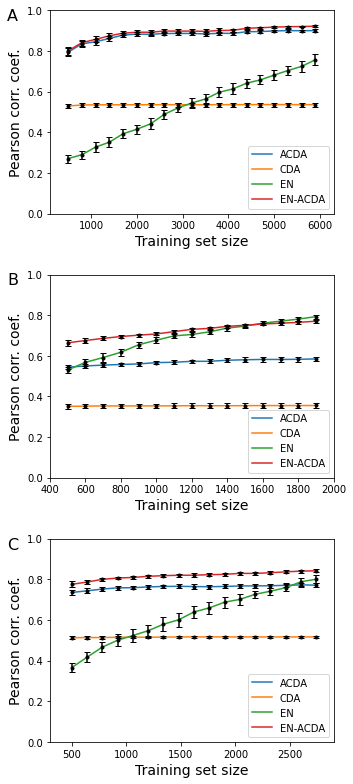

In [50]:
fig, ax = plt.subplots(3, 1, figsize=(5,11))
drawOneDownsampled(pd.read_csv('../output/downSample_4_breast_ASTRAZENECA_9_5900.csv', index_col=[0,1,2]), ax[0], 'A', 500, 5900, 400, 1)
drawOneDownsampled(pd.read_csv('../output/downSample_4_lung_ASTRAZENECA_9_1900.csv', index_col=[0,1,2]), ax[1], 'B', 500, 1900, 100, 1)
drawOneDownsampled(pd.read_csv('../output/downSample_4_urinary_tract_ASTRAZENECA_9_2740.csv', index_col=[0,1,2]), ax[2], 'C', 500, 2700, 200, 1)
fig.tight_layout()
plt.subplots_adjust(hspace=0.3)
fig.savefig('downsampling.png', dpi=600)
plt.show()

# Single datasets DrugComb

In [39]:
o = se_models_mutations_GDSC.index.intersection(df_DC.index.to_frame()['MODEL'].unique())
for_single = df_DC.loc[df_DC.index.to_frame()['MODEL'].isin(o)].index.to_frame()['STUDY'].groupby(level=['TISSUE', 'STUDY']).count()
for_single = for_single[for_single>1000].index
print(for_single.shape)

(19,)


In [40]:
(int(4382*2/3), int(4382*1/3)), (int(3510*2/3), int(3510*1/3)), (int(9878*2/3), int(9878*1/3)), 

((2921, 1460), (2340, 1170), (6585, 3292))

In [35]:
if False:
    for_single_datasets = dict()
    for tissue, study in for_single:
        print(tissue, '\t', study, end='\t')
        temp = prepareFromDCforCDA(df_DC, study, tissue, se_models_mutations_GDSC, sample=5*10**3)
        for_single_datasets.update({(tissue, study): temp})
        print(temp.shape)
else:
    for tissue, study in for_single:
        print(tissue, '\t', study, '\t', for_single_datasets[(tissue, study)].shape)
        if True:
            for_single_datasets[(tissue, study)].to_csv('../data/for_single_datasets_DC_%s_%s.csv.gz' % (tissue, study))

NameError: name 'for_single_datasets' is not defined

In [582]:
if False:
    tested_results_single = dict()

In [52]:
for tissue, study in for_single:
    fname = '../output/tested_results_single_i_DC_Cij_%s_%s.pklz' % (tissue, study)
    if not os.path.isfile(fname):
        print(tissue, study)
        temp = MonteCarloCrossValidation(for_single_datasets[(tissue, study)], n=10, clf_for_CDA=LinearRegression())
        with open(fname, 'wb') as outfile:
            pickle.dump({(tissue, study): temp}, outfile)

In [53]:
tested_results_single_restored = dict()
for tissue, study in for_single:
    fname = '../output/tested_results_single_i_DC_Cij_%s_%s.pklz' % (tissue, study)
    if os.path.isfile(fname):
        with open(fname, 'rb') as outfile:
            tested_results_single_restored.update(pickle.load(outfile))
            
ind = pd.MultiIndex.from_tuples(tested_results_single_restored.keys(), names=['TISSUE', 'STUDY'])
df_res_single = pd.concat([tested_results_single_restored[i][0].set_axis(['avg', 'sem'], axis=1) for i in ind], keys=ind, axis=1).T.unstack(-1).fillna(0)
df_res_single.style.background_gradient(axis=1)

In [54]:
df_res_single.xs('ASTRAZENECA', level='STUDY').style.background_gradient(axis=1)

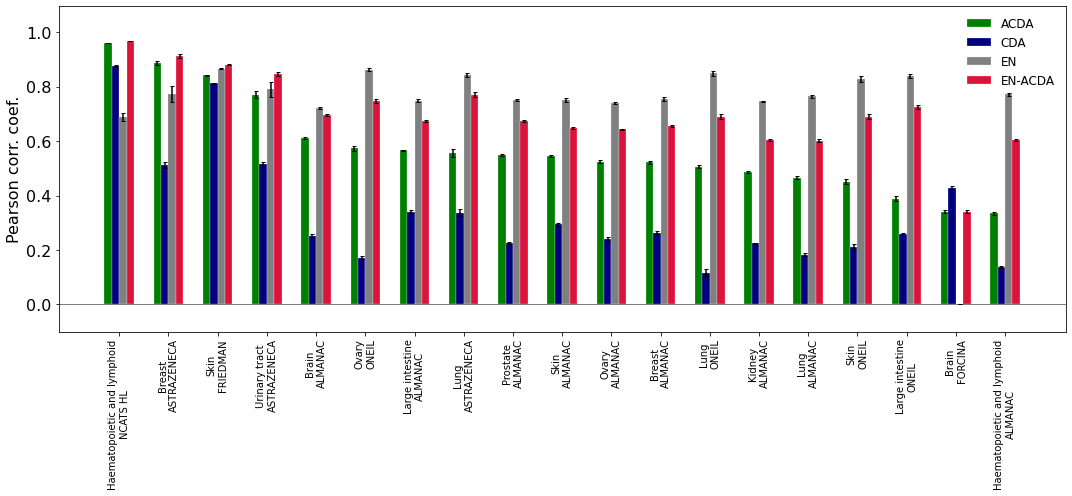

In [56]:
makeBarplotSingleDatasets(df_res_single.sort_values(by=('ACDA', 'avg'), ascending=False), figsize=(15, 7), saveName='barplot_single.png');

# Cross training DrugComb

In [41]:
o = se_models_mutations_GDSC.index.intersection(df_DC.index.to_frame()['MODEL'].unique())
df_DC_cut = df_DC.loc[df_DC.index.to_frame()['MODEL'].isin(o)]
for_cross_check = df_DC_cut.index.to_frame()['STUDY'].groupby(level=['TISSUE', 'STUDY']).count()
for_cross_check = for_cross_check.loc[[
            (                      'brain',     'ALMANAC'),
            (                      'brain',     'FORCINA'),
            (                     'breast',     'ALMANAC'),
            (                     'breast', 'ASTRAZENECA'),
            ('haematopoietic_and_lymphoid',     'ALMANAC'),
            ('haematopoietic_and_lymphoid',    'NCATS_HL'),
            (            'large_intestine',     'ALMANAC'),
            (            'large_intestine',       'ONEIL'),
            (                       'lung',     'ALMANAC'),
            (                       'lung', 'ASTRAZENECA'),
            (                       'lung',       'ONEIL'),
            (                      'ovary',     'ALMANAC'),
            (                      'ovary',       'ONEIL'),
            (                       'skin',     'ALMANAC'),
            (                       'skin',    'FRIEDMAN'),
            (                       'skin',       'ONEIL')]].index

In [42]:
cross_cases = []
for_cross_check_tissues = for_cross_check.get_level_values('TISSUE').unique().values.tolist()
print(for_cross_check_tissues)
for tissue in for_cross_check_tissues:
    studies = pd.Series(index=for_cross_check, dtype=object).xs(tissue, level='TISSUE').index.values
    cross_cases.append((tissue, studies[0], studies[1]))
    cross_cases.append((tissue, studies[1], studies[0]))
    if len(studies)==3:
        cross_cases.append((tissue, studies[0], studies[2]))
        cross_cases.append((tissue, studies[2], studies[0]))
        cross_cases.append((tissue, studies[1], studies[2]))
        cross_cases.append((tissue, studies[2], studies[1]))
print('Cases:', len(cross_cases))

['brain', 'breast', 'haematopoietic_and_lymphoid', 'large_intestine', 'lung', 'ovary', 'skin']
Cases: 22


In [43]:
tested_results_cross = dict()

for tissue, study1, study2 in cross_cases:
    fname = '../output/tested_results_cross_DC_i_Cij_%s_%s_%s.pklz' % (tissue, study1, study2)
    if not os.path.isfile(fname):
        print(tissue, study1, study2)
        temp = trainOneTestAnother(for_single_datasets[(tissue, study1)], for_single_datasets[(tissue, study2)], n=10)
        tested_results_cross.update({(tissue, study1, study2): temp})
        with open(fname, 'wb') as outfile:
            pickle.dump({(tissue, study1, study2): tested_results_cross[(tissue, study1, study2)]}, outfile)
    else:
        with open(fname, 'rb') as outfile:
            tested_results_cross.update(pickle.load(outfile))
            
ind = pd.Index(tested_results_cross.keys(), names=['TISSUE', 'STUDY1', 'STUDY2'])
df_res_cross = pd.concat([tested_results_cross[i][0].set_axis(['avg', 'sem'], axis=1) for i in ind], keys=ind, axis=1).T.unstack(-1).fillna(0)
df_res_cross.style.background_gradient(axis=1)

C:\Users\domans\AppData\Local\Temp\ipykernel_33432\3832691373.py:15: FutureWarning:

Passing keywords other than 'data', 'dtype', 'copy', 'name', 'tupleize_cols' is deprecated and will raise TypeError in a future version.  Use the specific Index subclass directly instead.



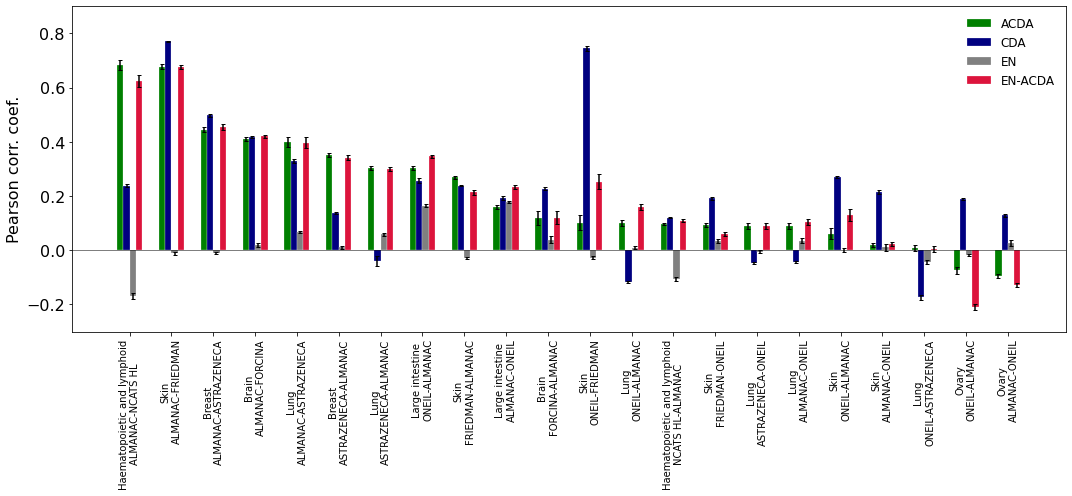

In [57]:
makeBarplotCrossDatasets(df_res_cross.sort_values(by=('ACDA', 'avg'), ascending=False), figsize=(15,7), saveName='barplot_cross.png');

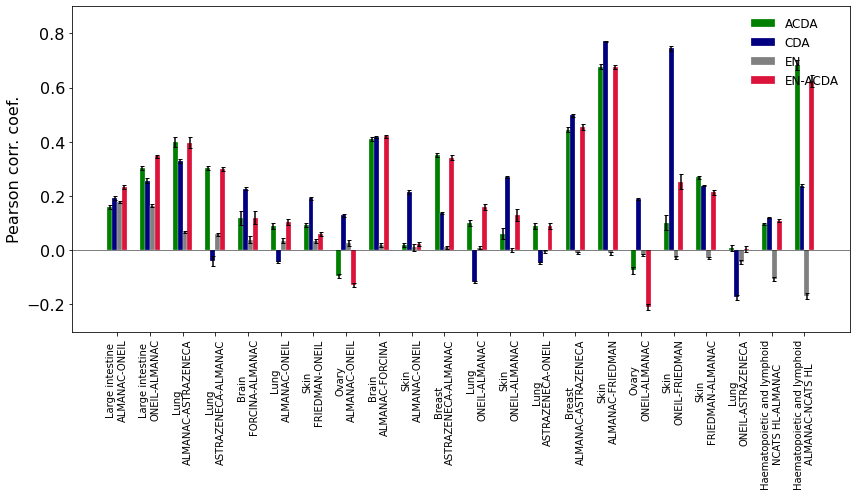

In [49]:
makeBarplotCrossDatasets(df_res_cross.sort_values(by=('EN', 'avg'), ascending=False), saveName='barplot_cross_EN.png');

In [61]:
df_DC.index.to_frame()['DRUG1'].unique()

array(['122111-05-1', '158798-73-3', '23541-50-6', ..., 'MRK003',
       'Pterostilbene', 'Rimcazole'], dtype=object)

# M on DC (>=1000 entries)

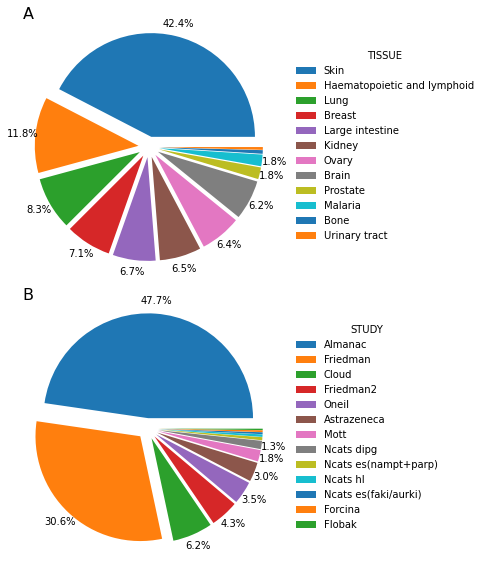

In [286]:
def plotCatPie(col, panel='', ax=None):
    se = df_DC.index.to_frame()[col].groupby(level=[col]).count().sort_values(ascending=False)
    se = se[se>=1000]

    def func(pct, allvals):
        if pct>=1:
            return "{:.1f}%".format(pct)
        else:
            return ''

    labels = se.index.values
    sizes = se.values
    explode = [0.1 for i in range(len(labels))]

    if ax is None:
        fig1, ax = plt.subplots(figsize=(6.5, 6))
        
    ax.pie(sizes, autopct=lambda pct: func(pct, sizes), explode=explode, labels=None, shadow=False, startangle=0, pctdistance=1.12) # , wedgeprops={'edgecolor': 'r'}
    ax.axis('equal')

    # ax.set_title(col)
    labels = pd.Series(se.index.values).str.capitalize().str.replace('_', ' ').values
    
    ax.legend(labels=labels, title=col, loc="center left", bbox_to_anchor=(1, 0, 0.5, 1), frameon=False)
    
    ax.text(ax.get_xlim()[0], ax.get_ylim()[1], panel , size=16)
    return

fig, axs = plt.subplots(ncols=1, nrows=2, figsize=(6.8, 8))
plotCatPie('TISSUE', panel='A', ax=axs[0])
plotCatPie('STUDY', panel='B', ax=axs[1])
fig.tight_layout()
fig.savefig('pies.png', facecolor='w', dpi=450)

In [165]:
def runOneJson(args):  
    try:
        synergy, size, dataset, tissue, df_train_test, df_validate = args

        if not os.path.isfile('output/%s_%s_%s.json' % (dataset, tissue, synergy)):
            print(synergy, '\t', size, '\t', dataset, '\t', tissue)
            res = testCase(df_train_test, df_validate, encode=True, useAllFeatures=False, cv=None)
            res.update({'synergy': synergy, 'size': size, 'dataset': dataset, 'tissue': tissue})

            with open('output/%s_%s_%s.json' % (dataset, tissue, synergy), 'w') as outfile:
                json.dump(res, outfile)
    except Exception as exception:
        print('Exception:', exception)
    
    return

In [174]:
params = []
for dataset in df_DC.index.get_level_values('STUDY').unique()[:]:
    df_study = df_DC.xs(dataset, level='STUDY')
    for tissue in ['skin', 'breast', 'lung', 'haematopoietic_and_lymphoid', 'large_intestine', 'kidney', 'ovary', 'brain']: # df_study.index.get_level_values('TISSUE').unique()[:3]:
        try:
            df_study_tissue = df_study.xs(tissue, level='TISSUE')
            df_study_tissue = df_study_tissue.sample(min(3*10**3, df_study_tissue.shape[0]), random_state=0)
            for synergy in ['SYNERGY_ZIP', 'SYNERGY_LOEWE', 'SYNERGY_HSA', 'SYNERGY_BLISS'][:]:
                df_temp = df_study_tissue[[synergy]].copy()
                size = df_temp.shape[0]
                if size>=10**3:
                    #print(size, '\t', synergy, '\t', dataset, '\t', tissue)
                    df_temp = df_temp.rename({synergy: 'SYNERGY_SCORE'}, axis=1)
                    df_train_test = df_temp.sample(int(size*2/3), random_state=0)
                    df_validate = df_temp.loc[~df_temp.index.isin(df_train_test.index)]

                    params.append((synergy, size, dataset, tissue, df_train_test, df_validate))
        except Exception as exception:
            pass
        
print(len(params))

92


In [320]:
for p in params:
    runOneJson(p)
    
sparams = []

dfs = []
for p in params:
    synergy, size, dataset, tissue, df_train_test, df_validate = p
    
    try:
        with open('output/%s_%s_%s.json' % (dataset, tissue, synergy), 'r') as outfile:
            res = json.load(outfile) 
        dfs.append(res)
        sparams.append(p)
    except:
        pass
    
df_res = pd.DataFrame(dfs).sort_values(by='tissue')
df_res = df_res.drop(['self', 'cv_mean', 'cv_std', 'ro', 'size'], axis=1).dropna().rename({'val': 'correlation'}, axis=1)
print(df_res.tissue.value_counts())
df_res['tissue'] = df_res['tissue'].str.capitalize().str.replace('_', ' ')
df_res

SYNERGY_LOEWE 	 3000 	 FRIEDMAN 	 skin
Exception: could not convert string to float: '\\N'
haematopoietic_and_lymphoid    16
skin                           15
large_intestine                12
lung                           12
breast                         12
brain                           8
ovary                           8
kidney                          4
Name: tissue, dtype: int64


,correlation,synergy,dataset,tissue
31,0.277,SYNERGY_BLISS,ALMANAC,Brain
30,0.248,SYNERGY_HSA,ALMANAC,Brain
29,0.306,SYNERGY_LOEWE,ALMANAC,Brain
28,0.412,SYNERGY_ZIP,ALMANAC,Brain
62,0.052,SYNERGY_BLISS,NCATS_DIPG,Brain
...,...,...,...,...
74,0.454,SYNERGY_BLISS,ONEIL,Skin
73,0.397,SYNERGY_HSA,ONEIL,Skin
72,0.523,SYNERGY_LOEWE,ONEIL,Skin
58,0.487,SYNERGY_BLISS,FRIEDMAN2,Skin


In [257]:
# makeViolinPlot(df_res, ['correlation'], 'All', 'tissue', panelHeight=8, panelWidth=10, xlabel='Pearson correlation coefficient', ylabel='', title='', cmap=cm.tab10, showFractions=False, fontsize=16, pointsSize=10, pointsAlpha=1, pointsPushBack=False) # 'cv_mean', 'cv_std', 'val', 'ro'

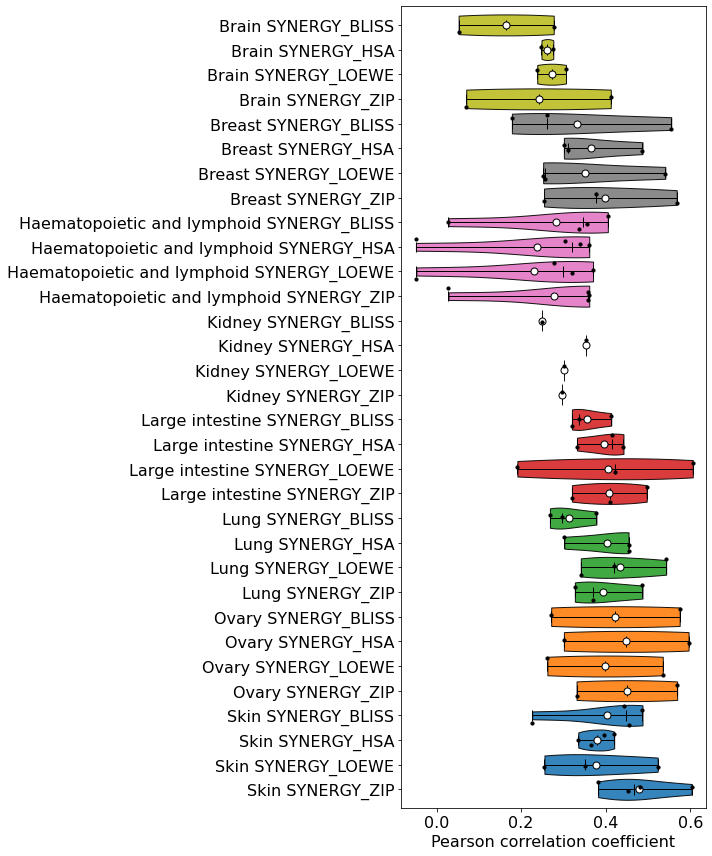

In [254]:
makeViolinPlot(df_res, ['correlation'], 'All', 'tissue|synergy', panelHeight=12, panelWidth=10, xlabel='Pearson correlation coefficient', ylabel='', title='', cmap=cm.tab10, showFractions=False, fontsize=16, pointsSize=10, pointsAlpha=1, pointsPushBack=False, excludeZeroValues=False, colorFactor=4)

In [336]:
dfsel = df_DC.reset_index()[['STUDY', 'TISSUE']]

makeSankeyDiagram(getCountsDataframe(dfsel['TISSUE'], dfsel['STUDY']), width=600, height=600)

Using default node colors


In [337]:
dfsel = df_DC.loc[(df_DC.index.get_level_values('STUDY').isin([p[2] for p in sparams])) & (df_DC.index.get_level_values('TISSUE').isin([p[3] for p in sparams]))].reset_index()[['STUDY', 'TISSUE']]

makeSankeyDiagram(getCountsDataframe(dfsel['TISSUE'], dfsel['STUDY']), width=575)

Using default node colors


# PDX predictions

In [661]:
df_drug_sensitivity_PDX = pd.read_csv('c:/Projects/A_PDX_drug_synergy/data/PDX_22models_sensitivity.csv', index_col=0).stack().to_frame().rename({0: 'LNIC50'}, axis=1)
df_drug_sensitivity_PDX.index.names = ['MODEL', 'DRUG']
df_drug_sensitivity_PDX

LNIC50
MODEL      DRUG               
J000080739 cisplatin        -6
           docetaxel         0
           doxorubicin      -6
J000099327 cisplatin        -6
           docetaxel        -6
...                        ...
TM01273    docetaxel        -6
           doxorubicin      -6
TM01278    cisplatin        -6
           docetaxel        -6
           doxorubicin      -6

[66 rows x 1 columns]

In [584]:
dfTas_PDX_breast = makeCDAformattedData('breast', se_drug_synergy_PDX, se_tissue_annotation_PDX, df_drug_sensitivity_PDX, se_models_mutations_PDX, se_drug_targets_PDX, 1., 'ONEIL')

0 Saving to cache...
39 cell lines, 1444 drug pairs
Synergy pairs in:	 22737
Synergy pairs out:	 2535
Data size: 56316
0 
With known synergy: 390
With unknown synergy: 8274


In [663]:
dfTas_GDSC_breast = makeCDAformattedData('Breast', se_drug_synergy_Narayan, se_tissue_annotation_GDSC, df_drug_sensitivity_GDSC, se_models_mutations_GDSC, se_drug_targets_GDSC, 1., 'GDSC')
dfTas_GDSC_breast

Loading from cache...
980 cell lines, 195364 drug pairs
Synergy pairs in:	 874
Synergy pairs out:	 258
Data size: 191456720
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
With known synergy: 122
With unknown synergy: 10158806


SYNERGY_SCORE   Tijk         Cij  \
MODEL    DRUG1       DRUG2       TISSUE                                     
AU565    foretinib   lapatinib   Breast            1.0   True   52.190979   
         lapatinib   foretinib   Breast            1.0   True   52.190979   
BT-20    gemcitabine mk-1775     Breast            1.0  False  273.959344   
         mk-1775     gemcitabine Breast            1.0  False  273.959344   
BT-474   azd8055     luminespib  Breast            1.0  False   84.216011   
...                                                ...    ...         ...   
ZR-75-30 zstk474     zg-10       Breast            NaN   True   52.190979   
                     zibotentan  Breast            NaN   True   52.190979   
                     zm447439    Breast            NaN   True   52.190979   
                     zoledronate Breast            NaN   True   52.190979   
                     zstk474     Breast            NaN   True    0.000000   

                                              Sik       Sjk  
MODEL    DRUG1       DRUG2       TISSUE                      
AU565    foretinib   lapatinib   Breast  1.362068 -0.819400  
         lapatinib   foretinib   Breast -0.819400  1.362068  
BT-20    gemcitabine mk-1775     Breast  0.539993  1.921266  
         mk-1775     gemcitabine Breast  1.921266  0.539993  
BT-474   azd8055     luminespib  Breast  0.776042 -2.503424  
...                                           ...       ...  
ZR-75-30 zstk474     zg-10       Breast       NaN  2.656206  
                     zibotentan  Breast       NaN       NaN  
                     zm447439    Breast       NaN  4.992117  
                     zoledronate Breast       NaN  5.101493  
                     zstk474     Breast       NaN       NaN  

[10158928 rows x 5 columns]

In [667]:
fcl = lambda df: df.loc[(~df['Cij'].isna()) & (~df['Sik'].isna()) & (~df['Sjk'].isna())] # & (~df['SYNERGY_SCORE'].isna())
df_temp = fcl(dfTas_GDSC_breast)
df_temp

SYNERGY_SCORE   Tijk         Cij  \
MODEL    DRUG1       DRUG2       TISSUE                                     
AU565    foretinib   lapatinib   Breast            1.0   True   52.190979   
         lapatinib   foretinib   Breast            1.0   True   52.190979   
BT-20    gemcitabine mk-1775     Breast            1.0  False  273.959344   
         mk-1775     gemcitabine Breast            1.0  False  273.959344   
BT-474   azd8055     luminespib  Breast            1.0  False   84.216011   
...                                                ...    ...         ...   
ZR-75-30 zoledronate xmd8-92     Breast            NaN  False    6.001339   
                     yk-4-279    Breast            NaN  False   21.598325   
                     zg-10       Breast            NaN  False   21.598325   
                     zm447439    Breast            NaN  False   21.598325   
                     zoledronate Breast            NaN  False    0.000000   

                                              Sik       Sjk  
MODEL    DRUG1       DRUG2       TISSUE                      
AU565    foretinib   lapatinib   Breast  1.362068 -0.819400  
         lapatinib   foretinib   Breast -0.819400  1.362068  
BT-20    gemcitabine mk-1775     Breast  0.539993  1.921266  
         mk-1775     gemcitabine Breast  1.921266  0.539993  
BT-474   azd8055     luminespib  Breast  0.776042 -2.503424  
...                                           ...       ...  
ZR-75-30 zoledronate xmd8-92     Breast  5.101493  5.109506  
                     yk-4-279    Breast  5.101493  6.484139  
                     zg-10       Breast  5.101493  2.656206  
                     zm447439    Breast  5.101493  4.992117  
                     zoledronate Breast  5.101493  5.101493  

[7955331 rows x 5 columns]

In [747]:
df_PDX = df_drug_sensitivity_PDX.copy().unstack(0)
u = df_PDX.index.unique().values
i = pd.MultiIndex.from_product([u, u])
i.names = ['DRUG1', 'DRUG2']
df_PDX = df_PDX.reindex(i.get_level_values('DRUG1'))
df_PDX.index = i
df_PDX = df_PDX.stack('MODEL')
df_PDX = df_PDX.loc[df_PDX.index.get_level_values('DRUG1')!=df_PDX.index.get_level_values('DRUG2')]
df_PDX.index = pd.MultiIndex.from_arrays([df_PDX.index.get_level_values('MODEL'), df_PDX.index.get_level_values('DRUG1'), df_PDX.index.get_level_values('DRUG2'), ['Breast']*len(df_PDX)],
                                           names=['MODEL', 'DRUG1', 'DRUG2', 'TISSUE'])
df_PDX = pd.DataFrame(index=df_PDX.index, columns=['SYNERGY_SCORE', 'Tijk', 'Cij', 'Sik', 'Sjk'])
df_PDX['Tijk'] = False

Cij = dict()
for drug1, drug2 in [('cisplatin', 'docetaxel'), ('cisplatin', 'doxorubicin'), ('docetaxel', 'doxorubicin'),
                    ('docetaxel', 'cisplatin'), ('doxorubicin', 'cisplatin'), ('doxorubicin', 'docetaxel')]:
    Cij[(drug1, drug2)] = dfTas_GDSC_breast.xs(drug1, level='DRUG1').xs(drug2, level='DRUG2')['Cij'].iloc[0]
Cij = pd.Series(Cij)
Cij

df_PDX['Cij'] = Cij.loc[df_PDX.index.droplevel(['MODEL', 'TISSUE'])].values
df_PDX['Sik'] = df_drug_sensitivity_PDX.loc[df_PDX.index.droplevel(['DRUG2', 'TISSUE'])].values
df_PDX['Sjk'] = df_drug_sensitivity_PDX.loc[df_PDX.index.droplevel(['DRUG1', 'TISSUE'])].values

df_PDX

,,,,SYNERGY_SCORE,Tijk,Cij,Sik,Sjk
MODEL,DRUG1,DRUG2,TISSUE,,,,,
J000080739,cisplatin,docetaxel,Breast,NaN,False,273.959344,-6,0
J000099327,cisplatin,docetaxel,Breast,NaN,False,273.959344,-6,-6
J000100674,cisplatin,docetaxel,Breast,NaN,False,273.959344,-6,-6
J000100675,cisplatin,docetaxel,Breast,NaN,False,273.959344,-6,3
J000101173,cisplatin,docetaxel,Breast,NaN,False,273.959344,-6,-6
...,...,...,...,...,...,...,...,...
TM00999,doxorubicin,docetaxel,Breast,NaN,False,13.564472,-6,-6
TM01079,doxorubicin,docetaxel,Breast,NaN,False,13.564472,-6,3
TM01117,doxorubicin,docetaxel,Breast,NaN,False,13.564472,-6,-6


In [754]:
def testRepeatPDX(dfTas, n=10):

    res = dict()
    for i in range(n):
        print(i)
        dfTas_copy = dfTas.copy()
        dfTas_copy.loc[dfTas_copy[dfTas_copy['SYNERGY_SCORE'].isna()].sample(100, random_state=0).index, 'SYNERGY_SCORE'] = 0.
        df_train_test, df_validate, df_predict = split_train_test_validate_predict(dfTas_copy, factor=2/3, random_state=i)
        
        df_train = pd.concat([df_train_test, df_validate])
        
        print(df_train.shape)

#         print('\n', 'M:')
#         res[('EN', i)] = testCase(df_train_test, df_validate, encode=True, useAllFeatures=False, cv=3)
#         print('\n', 'ACDA:')
#         res[('ACDA', i)] = testCase(df_train_test, df_validate, encode=False, useAllFeatures=False, cv=3)
#         print('\n', 'CDA:')
#         res[('CDA', i)] = testCase(df_train_test, df_validate, encode=False, useAllFeatures=False, cv=3, clf=LinearRegression())

#     df = pd.DataFrame(res).T.sort_index()
#     df = pd.concat([df.groupby(level=0).mean().round(3), df.groupby(level=0).sem().round(3)], keys=['mean', 'sem'], axis=1).xs('val', level=1, axis=1)
    
    return

testRepeatPDX(dfTas_GDSC_breast, n=1)

0

All pairs:		 10158928
Pairs with missing:	 2203597
All with known pairs:	 191
Training-testing pairs:	 127
Validation pairs:	 64
Prediction pairs:	 7955140
(191, 5)


In [777]:
def testCasePredict(df_train_test, df_validate, CDA_features=['Tijk', 'Cij', 'Sik', 'Sjk'], encode=False, useAllFeatures=False, cv=10, clf=None):
    
    if encode:
        dfe_train_test = encodeNames(df_train_test)
        dfe_train_test = dfe_train_test[dfe_train_test.columns.intersection(encodeNames(df_validate).columns)]
        dfe_validate = encodeNames(df_validate).reindex(dfe_train_test.columns, axis=1).fillna(0.).astype(int)
        
        df_train_test.loc[:, dfe_train_test.columns] = dfe_train_test.values
        df_validate.loc[:, dfe_validate.columns] = dfe_validate.values

        if useAllFeatures:
            # Exclude the predictee
            features = df_train_test.columns[~df_train_test.columns.isin(['SYNERGY_SCORE'])]
        else:
            # Exclude the predictee and CDA features, keep encoded drug and models
            features = df_train_test.columns[~df_train_test.columns.isin(['SYNERGY_SCORE'] + CDA_features)]
    else:
        features = CDA_features
        
    if clf is None:
        clf=RandomForestRegressor(random_state=0, max_depth=40, n_estimators=250)
        
    clf.fit(df_train_test[features].values, df_train_test['SYNERGY_SCORE'].values.astype(float))    
        
    return clf.predict(df_validate[features].values)


res = dict()
for i in range(10):
    print(i)
    dfTas_copy = dfTas_GDSC_breast.copy()
    dfTas_copy.loc[dfTas_copy[dfTas_copy['SYNERGY_SCORE'].isna()].sample(100, random_state=i).index, 'SYNERGY_SCORE'] = 0.
    df_train_test, df_validate, df_predict = split_train_test_validate_predict(dfTas_copy, factor=2/3, random_state=i)
    df_train = pd.concat([df_train_test, df_validate])

    res[('ACDA', i)] = pd.Series(index=df_PDX.index, data=testCasePredict(df_train, df_PDX, encode=False))
    res[('CDA', i)] = pd.Series(index=df_PDX.index, data=testCasePredict(df_train, df_PDX, encode=False, clf=LogisticRegression(random_state=0)))
    res[('EN', i)] = pd.Series(index=df_PDX.index, data=testCasePredict(df_train, df_PDX, encode=True))
    

0

All pairs:		 10158928
Pairs with missing:	 2203597
All with known pairs:	 191
Training-testing pairs:	 127
Validation pairs:	 64
Prediction pairs:	 7955140
1

All pairs:		 10158928
Pairs with missing:	 2203597
All with known pairs:	 192
Training-testing pairs:	 128
Validation pairs:	 64
Prediction pairs:	 7955139
2

All pairs:		 10158928
Pairs with missing:	 2203597
All with known pairs:	 189
Training-testing pairs:	 126
Validation pairs:	 63
Prediction pairs:	 7955142
3

All pairs:		 10158928
Pairs with missing:	 2203597
All with known pairs:	 193
Training-testing pairs:	 128
Validation pairs:	 65
Prediction pairs:	 7955138
4

All pairs:		 10158928
Pairs with missing:	 2203597
All with known pairs:	 187
Training-testing pairs:	 124
Validation pairs:	 63
Prediction pairs:	 7955144
5

All pairs:		 10158928
Pairs with missing:	 2203597
All with known pairs:	 189
Training-testing pairs:	 126
Validation pairs:	 63
Prediction pairs:	 7955142
6

All pairs:		 10158928
Pairs with missing:	 

In [779]:
f = lambda m, n: pd.concat([res[(m, i)] for i in range(n)], axis=1).mean(axis=1)
methods = ['ACDA', 'CDA', 'EN']
se = pd.concat([f(m, 10) for m in methods], keys=methods, axis=1)
se

,,,,ACDA,CDA,EN
MODEL,DRUG1,DRUG2,TISSUE,,,
J000080739,cisplatin,docetaxel,Breast,0.7908,1.0,0.948729
J000099327,cisplatin,docetaxel,Breast,0.5592,1.0,0.948729
J000100674,cisplatin,docetaxel,Breast,0.5592,1.0,0.948729
J000100675,cisplatin,docetaxel,Breast,0.3644,1.0,0.948729
J000101173,cisplatin,docetaxel,Breast,0.5592,1.0,0.948729
...,...,...,...,...,...,...
TM00999,doxorubicin,docetaxel,Breast,0.6288,1.0,0.995000
TM01079,doxorubicin,docetaxel,Breast,0.3408,1.0,0.995000
TM01117,doxorubicin,docetaxel,Breast,0.6288,1.0,0.995000


array([[<AxesSubplot:title={'center':'ACDA'}>,
        <AxesSubplot:title={'center':'CDA'}>],
       [<AxesSubplot:title={'center':'EN'}>, <AxesSubplot:>]],
      dtype=object)

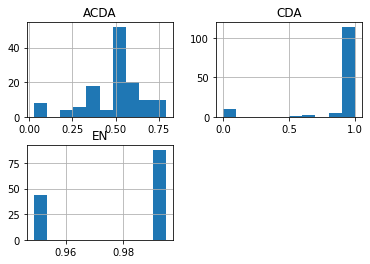

In [780]:
se.hist()

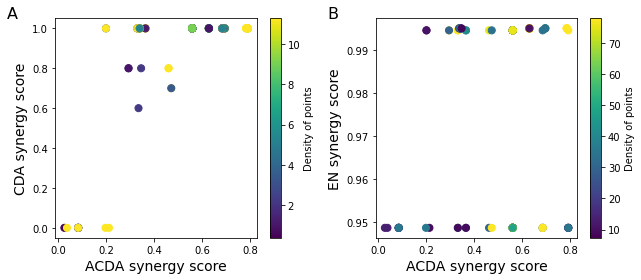

In [876]:
fig, ax = plt.subplots(1, 2, figsize=(9,4))

def f(a, b, ax, p, ms=50):
    xy = np.vstack([se[a].values, se[b].values])
    z = gaussian_kde(xy)(xy)
    o = z.argsort()
    d = ax.scatter(se[a][o], se[b][o], c=z, s=ms)
    ax.set_xlabel('%s synergy score' % a, fontsize=14)
    ax.set_ylabel('%s synergy score' % b, fontsize=14)  
    ax.text(ax.get_xlim()[0]-0.2, ax.get_ylim()[1], p, fontsize=16)
    return d
    
d1 = f('ACDA', 'CDA', ax[0], 'A')
d2 = f('ACDA', 'EN', ax[1], 'B')

fig.colorbar(d1, label='Density of points', ax=ax[0])
fig.colorbar(d2, label='Density of points', ax=ax[1])

fig.tight_layout()

fig.savefig('PDX.scores.png', dpi=600, facecolor='w')

In [850]:
sel = se.loc[se.ACDA>=0.7][['ACDA']].droplevel('TISSUE').reorder_levels([1,2,0])
sel.to_excel('sel_PDX.xlsx')
sel

ACDA
DRUG1       DRUG2     MODEL             
cisplatin   docetaxel J000080739  0.7908
                      J000102184  0.7908
                      TM00096     0.7908
                      TM00107     0.7908
doxorubicin cisplatin TM00113     0.7908
            docetaxel J000080739  0.7844
                      J000102184  0.7844
                      TM00090     0.7844
                      TM00096     0.7844
                      TM00107     0.7844

# Simulation AUC vs Pearson

In [621]:
from sklearn.metrics import roc_auc_score, f1_score

In [622]:
np.random.seed(2)
N = 10000
M = 8000

def f(M):
    y_true = np.random.choice([0, 1], N, p=[0.2,0.8])
    y_pred = y_true.copy()
    wh = np.sort(np.random.choice(range(N), M, replace=False))
    y_pred[wh] = np.random.choice([0, 1], M)
    return {'AUC': roc_auc_score(y_true, y_pred), 'F1': f1_score(y_true, y_pred), 'Pearson': pearsonr(y_true, y_pred)[0]}

resm = dict()
for M in range(10**2, 10**4, 10**1):
    resm.update({M: f(M)})

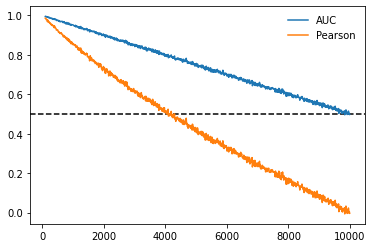

In [641]:
dftemp = pd.DataFrame(resm).T
dftemp['Pearson scaled'] = dftemp['Pearson']/2 + 0.5
dftemp[['AUC', 'Pearson']].plot()
plt.axhline(0.5, linestyle='--', color='k', zorder=-1)
# plt.xlim(0, 10**4)
# plt.ylim(0, 1)
plt.legend(frameon=False)

### Run RandomizedSearchCV

In [124]:
random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)] + [None],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}

clf = RandomForestClassifier(random_state=0, max_depth=20, n_estimators=300)
rf_random = RandomizedSearchCV(estimator=clf, param_distributions=random_grid, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)

index = df_train_test.index
inSynergy = (df_train_test.loc[index]['SYNERGY_SCORE']>=synergy_cutoff).astype(float).values
inData = df_train_test.loc[index][L].astype(float).copy()

rf_random.fit(inData, inSynergy)

rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(max_depth=20,
                                                    n_estimators=300,
                                                    random_state=0),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]}

### Evaluate RandomSearchCV findings

In [129]:
inSynergyV = (df_validate['SYNERGY_SCORE']>=synergy_cutoff).astype(float).values
inDataV = df_validate[L].astype(float).copy()

In [151]:
def evaluate(model, test_features, test_labels):
    accuracy = accuracy_score(test_labels, model.predict(test_features))
    f1score = f1_score(test_labels, model.predict(test_features))
    print('Accuracy = {:0.2f}%.'.format(100 * accuracy))
    print('F1 score = {:0.2f}%.'.format(100 * f1score))
    return accuracy

base_model = RandomForestClassifier(n_estimators=500, random_state=42)
base_model.fit(inData, inSynergy)
base_accuracy = evaluate(base_model, inDataV, inSynergyV)

best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, inDataV, inSynergyV)
print('Improvement of {:0.2f}%.'.format(100 * (random_accuracy - base_accuracy) / base_accuracy))

Accuracy = 77.76%.
F1 score = 32.15%.
Accuracy = 79.57%.
F1 score = 16.47%.
Improvement of 2.33%.


### Run GridSearchCV

In [148]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [10, 20],
    'max_features': [2, 3],
    'min_samples_leaf': [2, 3],
    'min_samples_split': [4, 5, 6],
    'n_estimators': [750, 1000]
}
rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(inData, inSynergy)
grid_search.best_params_

Fitting 3 folds for each of 48 candidates, totalling 144 fits


{'bootstrap': True,
 'max_depth': 10,
 'max_features': 2,
 'min_samples_leaf': 2,
 'min_samples_split': 6,
 'n_estimators': 750}

In [153]:
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, inDataV, inSynergyV)
print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

Accuracy = 79.57%.
F1 score = 16.33%.
Improvement of 2.33%.


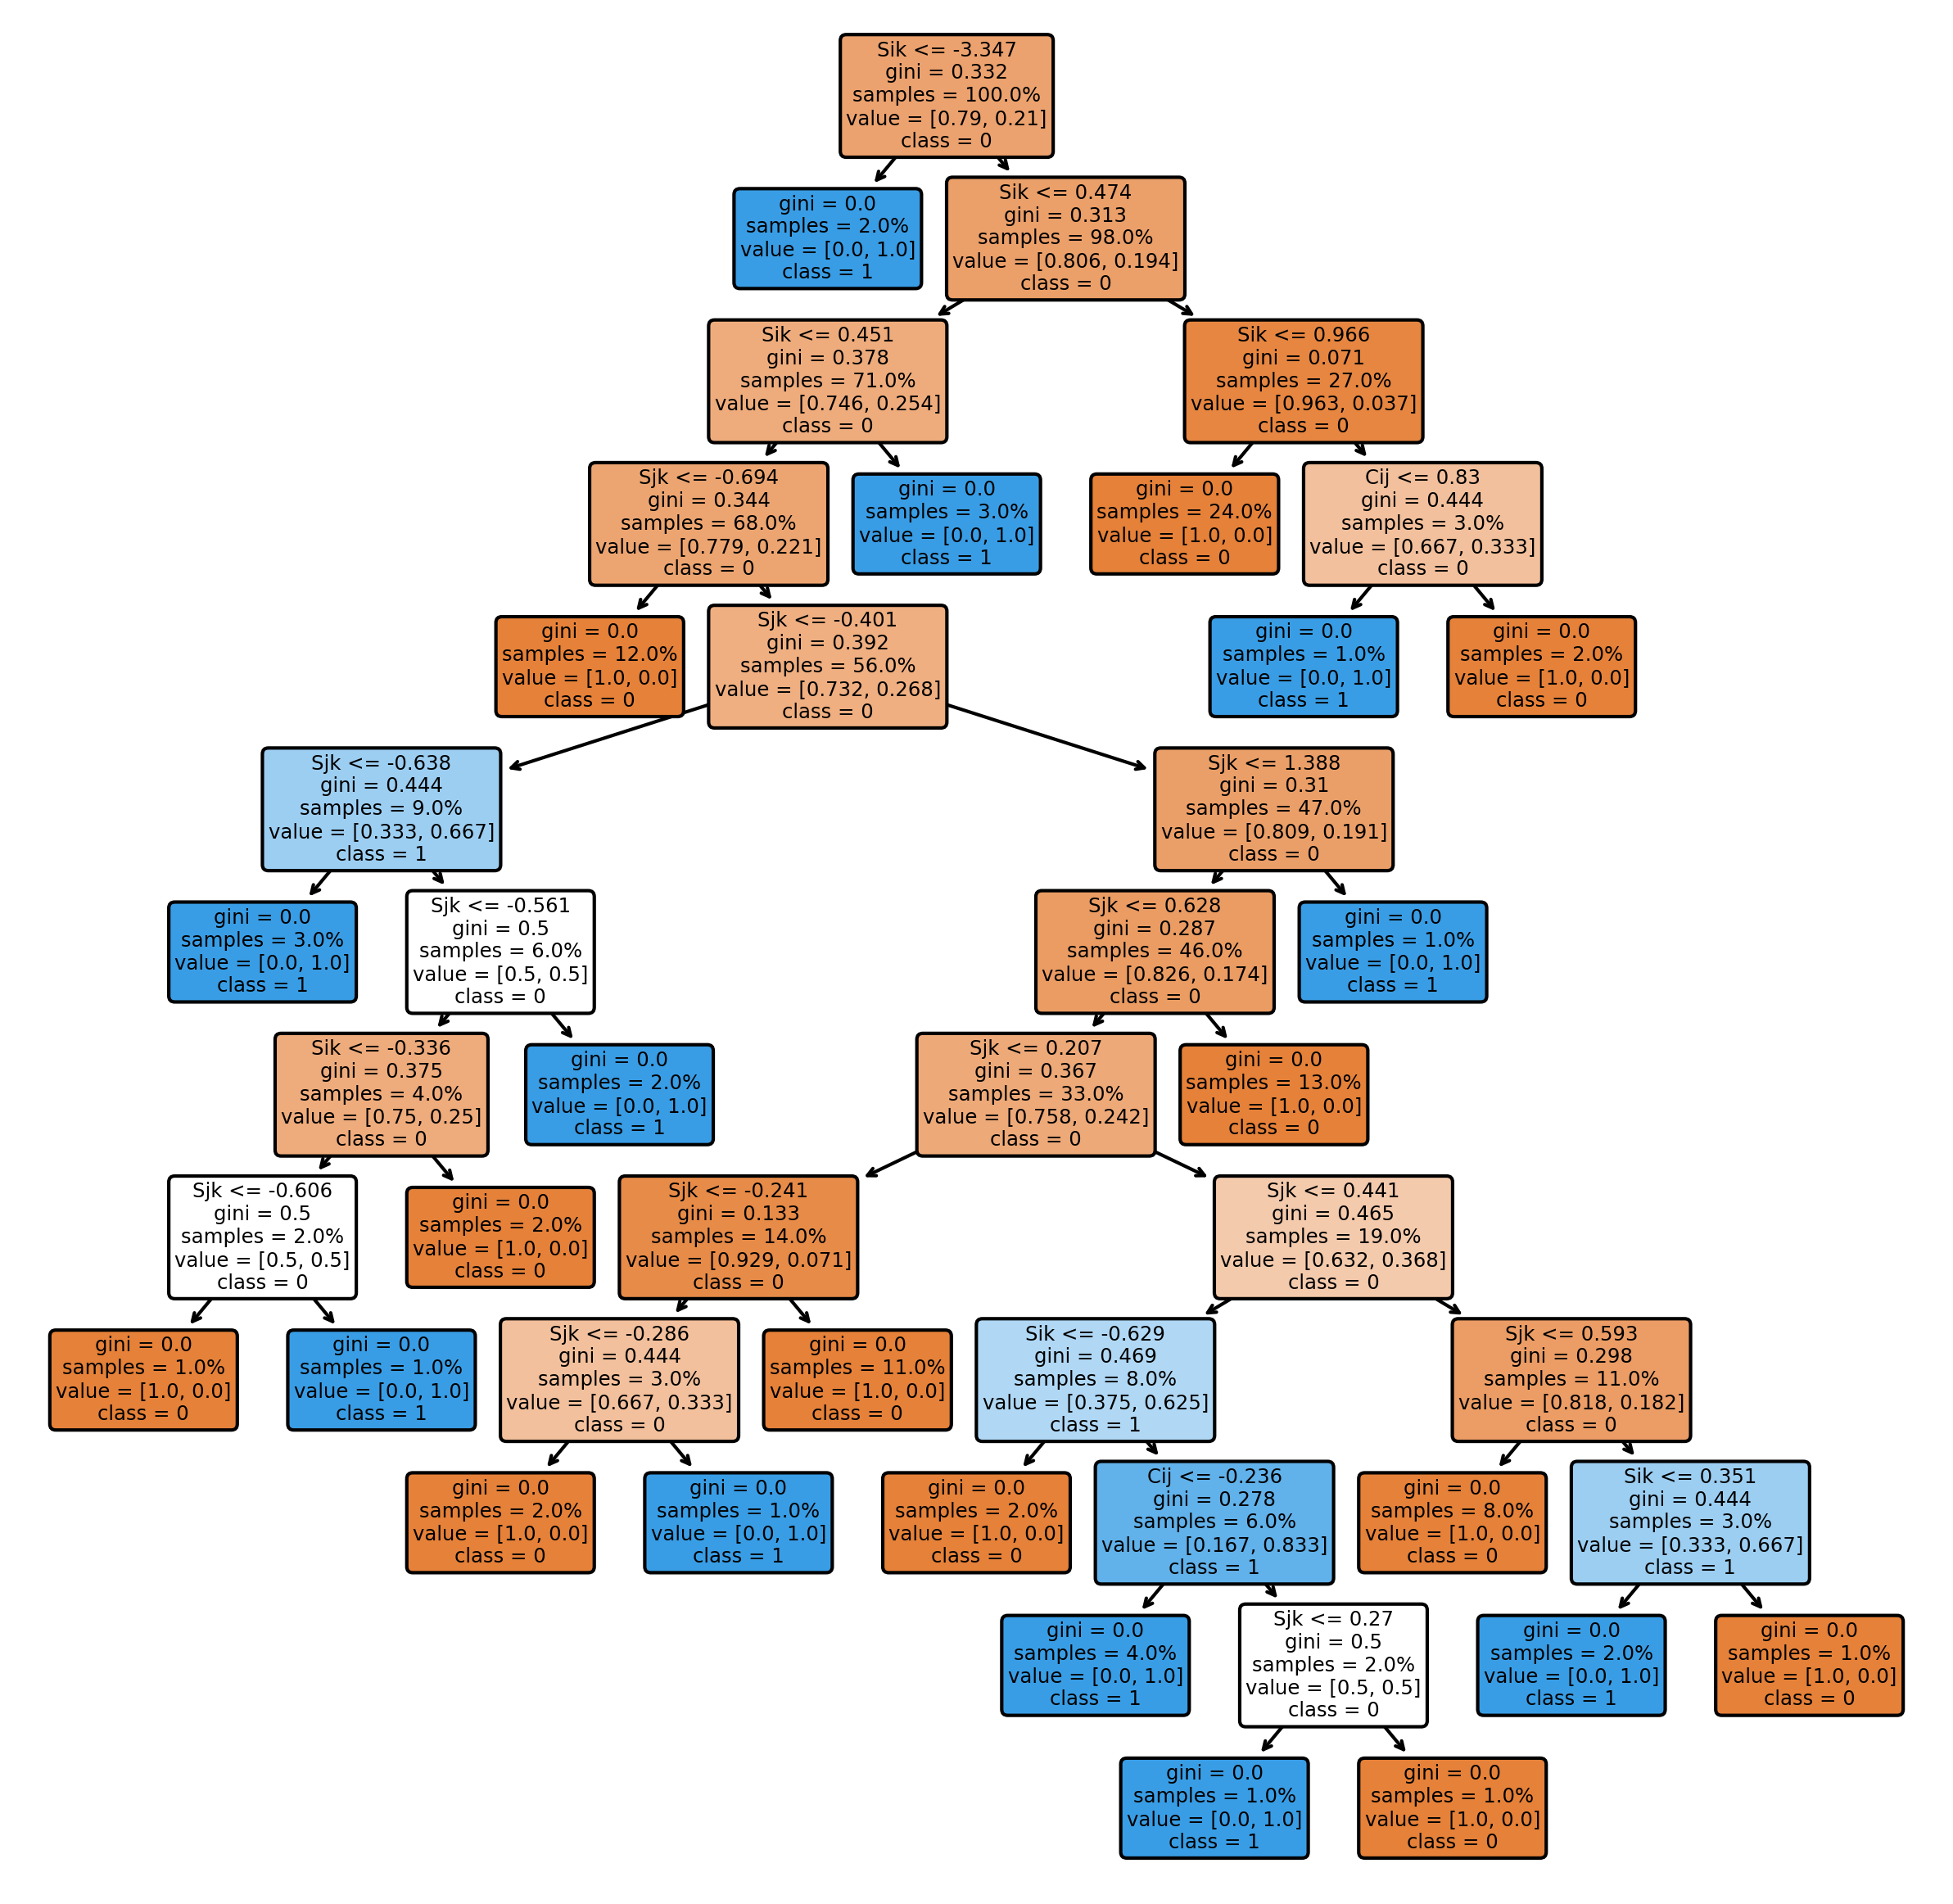

In [104]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (10, 10), dpi=300)
tree.plot_tree(clf, ax=ax, feature_names=L, class_names=['0', '1'], filled=True, proportion=True, rounded=True);

# Visualization

In [251]:
# df_AZ_DC, dfC_AZ_DC, dfS_AZ_DC, Z_AZ_DC = prepareFromDCforCDA(df_DC, 'ASTRAZENECA', 'breast', se_models_mutations_GDSC, sample=None, returnMore=True) # symmetrized already
# df_AZ_DC

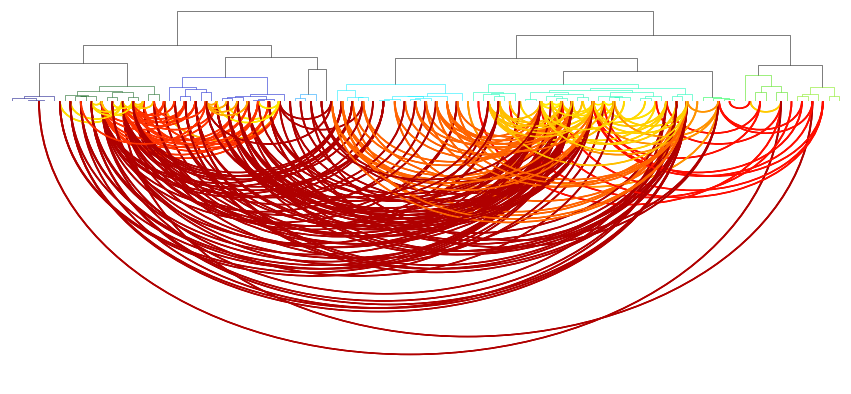

In [254]:
temp = df_AZ_DC['SYNERGY_SCORE'].droplevel(['MODEL', 'TISSUE'])
plotDendrogramWithKnownPairs(Z_AZ_DC, dfC_AZ_DC, temp[temp>=20].index.unique())

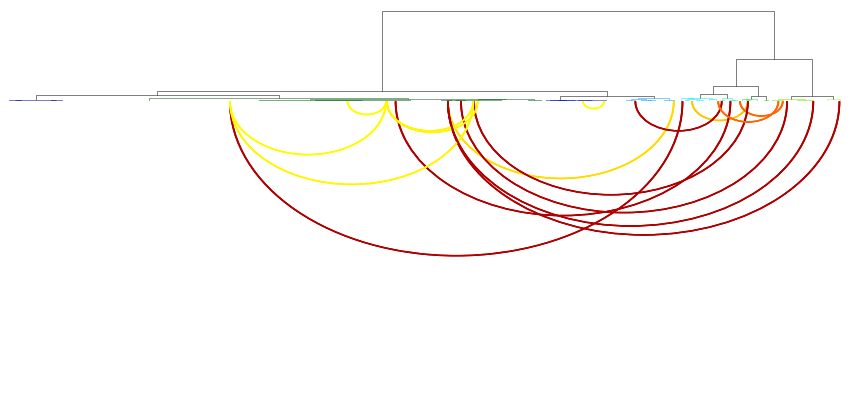

In [253]:
# temp = df_G2['SYNERGY_SCORE'].droplevel(['MODEL', 'TISSUE'])
# plotDendrogramWithKnownPairs(Z_G2, dfC_G2, temp[temp>=0].index.unique())

In [169]:
df_G2, dfC_G2, dfS_G2, Z_G2 = makeCDAformattedData('Breast', se_drug_synergy_Narayan, se_tissue_annotation_GDSC, df_drug_sensitivity_GDSC2, se_models_mutations_GDSC, se_drug_targets_GDSC, 1., 'GDSC2', returnMore=True)
df_G2

Loading from cache...
803 cell lines, 34969 drug pairs
Synergy pairs in:	 874
Synergy pairs out:	 134
Data size: 28080107
0 1 2 
With known synergy: 74
With unknown synergy: 1783345


SYNERGY_SCORE   Tijk        Cij  \
MODEL    DRUG1       DRUG2       TISSUE                                    
AU565    foretinib   lapatinib   Breast            1.0   True  12.623131   
         lapatinib   foretinib   Breast            1.0   True  12.623131   
BT-20    gemcitabine mk-1775     Breast            1.0  False  18.986004   
         mk-1775     gemcitabine Breast            1.0  False  18.986004   
BT-474   azd8055     luminespib  Breast            1.0  False  50.876669   
...                                                ...    ...        ...   
ZR-75-30 zoledronate wz4003      Breast            NaN  False   0.657754   
                     xav939      Breast            NaN  False   4.253106   
                     yk-4-279    Breast            NaN  False  12.623131   
                     zm447439    Breast            NaN  False   7.727402   
                     zoledronate Breast            NaN  False   0.000000   

                                              Sik       Sjk  
MODEL    DRUG1       DRUG2       TISSUE                      
AU565    foretinib   lapatinib   Breast  1.080738 -0.819400  
         lapatinib   foretinib   Breast -0.819400  1.080738  
BT-20    gemcitabine mk-1775     Breast  2.930021  1.921266  
         mk-1775     gemcitabine Breast  1.921266  2.930021  
BT-474   azd8055     luminespib  Breast  1.047488 -1.770203  
...                                           ...       ...  
ZR-75-30 zoledronate wz4003      Breast  5.101493  5.864494  
                     xav939      Breast  5.101493  5.534174  
                     yk-4-279    Breast  5.101493  6.484139  
                     zm447439    Breast  5.101493  4.432672  
                     zoledronate Breast  5.101493  5.101493  

[1783419 rows x 5 columns]

In [243]:
def temp_get_predicted(df_G2, random_state):
    df_copy = df_G2.copy()
    df_copy = df_copy.loc[~df_copy[['Tijk', 'Cij', 'Sik', 'Sjk']].isna().any(axis=1)]
    df_copy.loc[df_copy[df_copy['SYNERGY_SCORE'].isna()].sample(100, random_state=random_state).index, 'SYNERGY_SCORE'] = 0.
    df_train_test = df_copy[~df_copy['SYNERGY_SCORE'].isna()]

    df_validate = df_copy[df_copy['SYNERGY_SCORE'].isna()]
    df_validate

    clf = fit_validate_predict(df_train_test[['Tijk', 'Cij', 'Sik', 'Sjk']].values, df_train_test['SYNERGY_SCORE'].values, cv=None, clf=None)

    se_predicted = pd.Series(index=df_validate.index, data=clf.predict(df_validate[['Tijk', 'Cij', 'Sik', 'Sjk']].values))
    return se_predicted

se_predicted = pd.concat([temp_get_predicted(df_G2, i) for i in range(10)], axis=1)
se_predicted = se_predicted.unstack(0).groupby(level=1, axis=1).agg(np.nanmean).stack().reorder_levels([3, 0, 1, 2]).sort_index()
se_predicted

On self:		 0.96619
On self:		 0.96487
On self:		 0.97085
On self:		 0.97074
On self:		 0.96739
On self:		 0.96973
On self:		 0.96883
On self:		 0.97563
On self:		 0.9741
On self:		 0.96796


MODEL     DRUG1           DRUG2           TISSUE
AU565     5-fluorouracil  5-fluorouracil  Breast    0.3652
                          abt737          Breast    0.1396
                          afatinib        Breast    0.2620
                          afuresertib     Breast    0.3660
                          agi-5198        Breast    0.0716
                                                     ...  
ZR-75-30  zoledronate     wz4003          Breast    0.0724
                          xav939          Breast    0.0000
                          yk-4-279        Breast    0.0000
                          zm447439        Breast    0.0028
                          zoledronate     Breast    0.0424
Length: 1460155, dtype: float64

In [257]:
clf.predict(df_validate[['Tijk', 'Cij', 'Sik', 'Sjk']].values)

array([0.632, 0.264, 0.432, ..., 0.   , 0.008, 0.012])

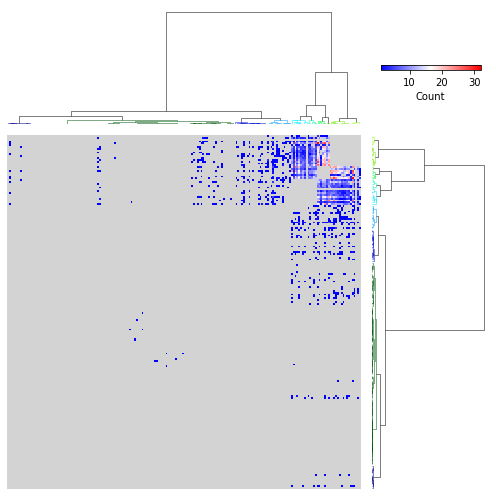

In [256]:
plotH2(dfC_G2, Z_G2, se_predicted[se_predicted>=0.95].index.droplevel(-1).values)

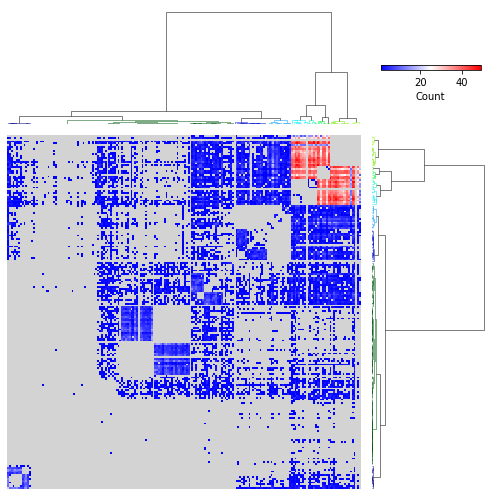

In [220]:
plotH2(dfC_G2, Z_G2, se_predicted[se_predicted>=0.75].index.droplevel(-1).values)

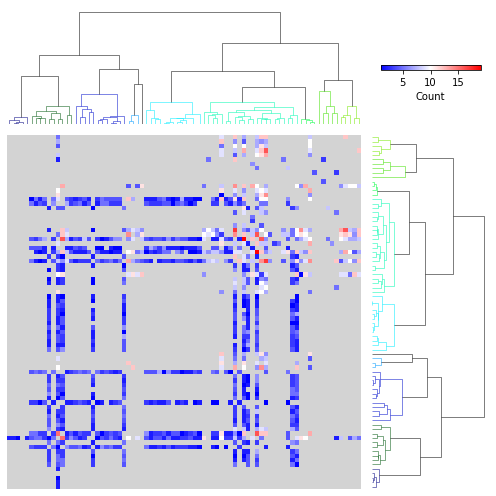

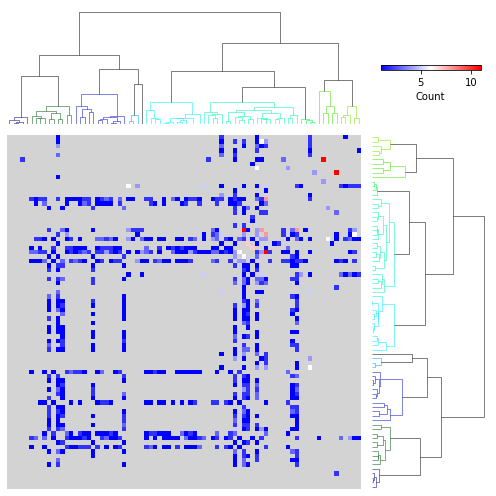

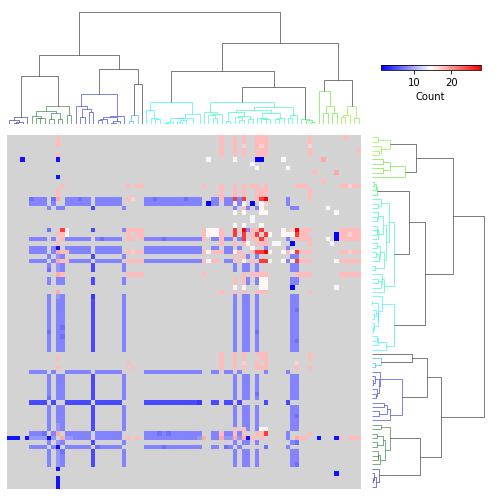

In [151]:
# plotH2(dfC_AZ_DC, Z_AZ_DC, res.loc[res.p>=0.9].index.droplevel(-1).values)
plotH2(dfC_AZ_DC, Z_AZ_DC, df_AZ_DC.loc[df_AZ_DC['SYNERGY_SCORE']<=0].index.droplevel(-1).values)
plotH2(dfC_AZ_DC, Z_AZ_DC, df_AZ_DC.loc[df_AZ_DC['SYNERGY_SCORE']>=10].index.droplevel(-1).values)
plotH2(dfC_AZ_DC, Z_AZ_DC, df_AZ_DC.loc[df_AZ_DC['SYNERGY_SCORE']>=-np.inf].index.droplevel(-1).values)

# features=['Tijk', 'Cij', 'Sik', 'Sjk']
# r, res = fit_validate_predict(df_train_test[features].values, df_train_test['SYNERGY_SCORE'].values, extData=df_validate[features].values, extSynergy=df_validate['SYNERGY_SCORE'].values, cv=None, clf=None)

# df_AZ_DC # 12606

# df = df_AZ_DC.copy()
# df[]

In [115]:
um = df.index.to_frame()['MODEL'].unique()
ud1 = df.index.to_frame()['DRUG1'].unique()
ud2 = df.index.to_frame()['DRUG2'].unique()

print(um.shape, ud1.shape, ud2.shape)

(28,) (80,) (80,)


In [159]:
findex = pd.MultiIndex.from_product([um, ud1, ud2, ['breast']], names=['MODEL', 'DRUG1', 'DRUG2', 'TISSUE'])
df.reindex(findex)

SYNERGY_SCORE   Tijk  \
MODEL    DRUG1     DRUG2                  TISSUE                         
BT-20    001, RAD  AZD2014                breast      -3.872081  False   
                   AZD5363                breast      -4.898580   True   
                   957054-30-7            breast            NaN    NaN   
                   AZD4320                breast            NaN    NaN   
                   AZD8186                breast            NaN    NaN   
...                                                         ...    ...   
UACC-812 TNF-Alpha Carboplatin Paclitaxel breast            NaN    NaN   
                   Gefitinib              breast            NaN    NaN   
                   MEDI3622               breast            NaN    NaN   
                   MED-575                breast            NaN    NaN   
                   Vandetanib             breast            NaN    NaN   

                                                       Cij     Sik     Sjk  
MODEL    DRUG1     DRUG2                  TISSUE                            
BT-20    001, RAD  AZD2014                breast  1.264700  40.432  37.158  
                   AZD5363                breast  1.993502  40.875  25.159  
                   957054-30-7            breast       NaN     NaN     NaN  
                   AZD4320                breast       NaN     NaN     NaN  
                   AZD8186                breast       NaN     NaN     NaN  
...                                                    ...     ...     ...  
UACC-812 TNF-Alpha Carboplatin Paclitaxel breast       NaN     NaN     NaN  
                   Gefitinib              breast       NaN     NaN     NaN  
                   MEDI3622               breast       NaN     NaN     NaN  
                   MED-575                breast       NaN     NaN     NaN  
                   Vandetanib             breast       NaN     NaN     NaN  

[179200 rows x 5 columns]

In [164]:
df.reindex(findex)['Sik'].dropna()

MODEL     DRUG1         DRUG2        TISSUE
BT-20     001, RAD      AZD2014      breast    40.432
                        AZD5363      breast    40.875
          1309805-49-9  AZD2014      breast    19.110
                        AZD5363      breast    24.365
                        957054-30-7  breast    18.645
                                                ...  
UACC-812  XL765         Olaparib     breast     8.709
                        Sapitinib    breast     1.903
                        Gefitinib    breast     3.247
                        MED-575      breast     3.092
                        Vandetanib   breast    -5.804
Name: Sik, Length: 12606, dtype: float64

In [86]:
# df_temp = df.copy()
# df_temp.index.names = ['MODEL', 'DRUG2', 'DRUG1', 'TISSUE']
# df_temp.columns = ['SYNERGY_SCORE', 'Tijk', 'Cij', 'Sjk', 'Sik']
# df_temp = df_temp.reorder_levels([0,2,1,3])[['SYNERGY_SCORE', 'Tijk', 'Cij', 'Sik', 'Sjk']]
# df = pd.concat([df, df_temp], axis=0)
# # pd.MultiIndex.from_frame(df.index.to_frame()[['MODEL', 'DRUG2', 'DRUG1', 'TISSUE']])
# # df_temp.index = 
# df

In [127]:
se = df['Sik'].droplevel(['DRUG2', 'TISSUE'])
se = se.loc[~se.index.duplicated()]
se

MODEL     DRUG1                                    
BT-20     001, RAD                                     40.432
          1309805-49-9                                 18.645
          3'-Epi Gemcitabine (Gemcitabine Impurity)    58.532
          41575-94-4                                   25.465
          957054-30-7                                  26.476
                                                        ...  
UACC-812  Vorinostat                                    1.007
          XL765                                         3.335
          chloroquine                                   4.747
          tamoxifen                                    -7.421
          Onalespib                                    70.982
Name: Sik, Length: 1078, dtype: float64

In [128]:
28*80

2240

In [155]:
#se1 = df_DC.xs('ASTRAZENECA', level='STUDY').xs('breast', level='TISSUE').droplevel('DRUG2')['AUC_DRUG1']
#se2 = df_DC.xs('ASTRAZENECA', level='STUDY').xs('breast', level='TISSUE').droplevel('DRUG1')['AUC_DRUG2']

se1 = df_DC.droplevel(['DRUG2', 'STUDY', 'TISSUE'])['AUC_DRUG1']
se2 = df_DC.droplevel(['DRUG1', 'STUDY', 'TISSUE'])['AUC_DRUG2']
se = pd.concat([se1, se2])
se = se.loc[~se.index.duplicated()]

se.shape, se.index.get_level_values(0).unique().shape, se.index.get_level_values(1).unique().shape

((27009,), (288,), (4268,))

In [158]:
288*4268

1229184

In [157]:
se

MODEL         DRUG1                              
786-0         122111-05-1                             6.673
              158798-73-3                             5.668
              23541-50-6                              5.922
              5-Aminolevulinic acid hydrochloride    11.018
              5-Fluoro-2'-deoxyuridine               -4.599
                                                      ...  
SMS-CTR       Trametinib                             37.657
              200484-11-3                            43.465
SU-DIPG-XIII  Cobimetinib (R-enantiomer)             14.723
              Trametinib                             54.137
              200484-11-3                             1.858
Length: 27009, dtype: float64

In [65]:
# res.loc[res.p>=0.9].index.droplevel(-1).values

In [268]:
# dfC, dfS, Z = getDistanceAndSensitivityData('Both', 'cosine')

# cf = []
# for i in range(100):
#     clf = runForTissueT('Bladder', dfC, dfS, dfTas_synergy, dfTas_no_synergy.sample(n=10**4))
#     cf.append(clf.coef_.tolist()[0] + [clf.intercept_[0]])
#     print(i, end=' ')
# print()
# df = pd.DataFrame(cf)
# df = pd.concat([df.mean(), df.apply(np.median), df.std()], axis=1).T
# df.columns = ['T_ijk', 'C_ij', 'S_ki', 'S_kj', 'intercept']
# df.index = ['avg', 'med', 'std']
# print(df)
# useQu = 'med'
# clf.coef_ = df.loc[useQu].values[None, :-1]
# clf.intercept_ = df.loc[useQu].values[None, -1]

res = runForTissueT('Breast', dfC, dfS, dfTas_synergy, dfTas_no_synergy.sample(n=10**4), df_outData=dfTas_no_synergy, clf=clf)
res.shape

(7955275, 6)

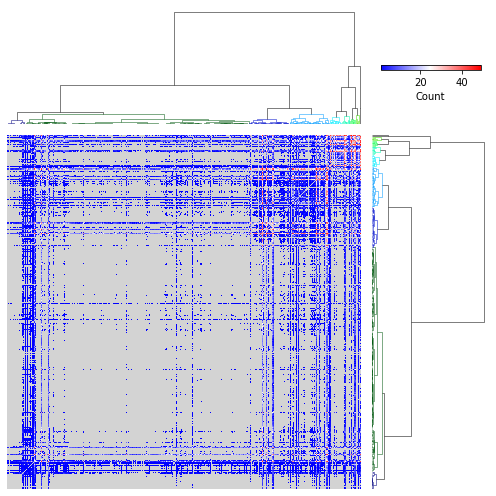

In [278]:
plotH2(dfC, Z, res.loc[res.p>=0.9].index.droplevel(-1).values)

(442, 52) 195364


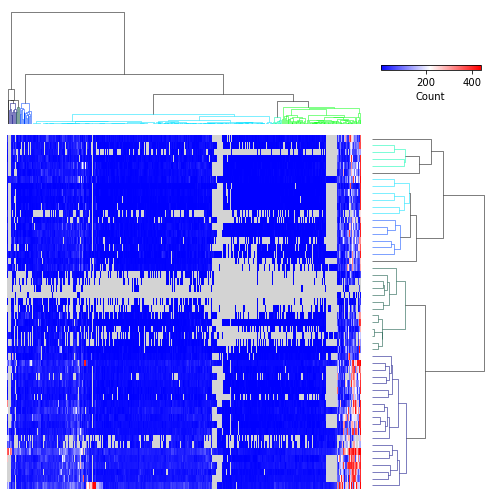

In [284]:
plotH3(dfC, Z, res.loc[res.p>=0.9].index.droplevel(-1).values)

(52463, 52)
(200, 52)


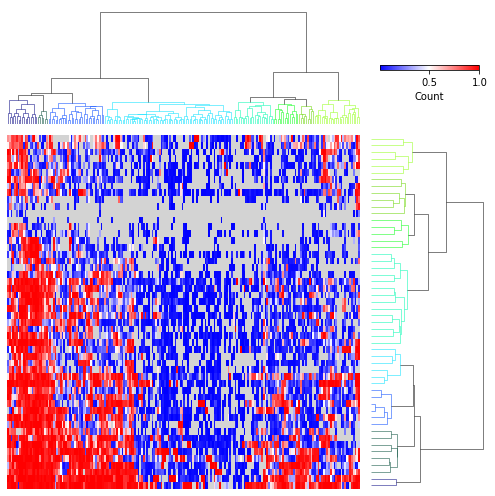

In [290]:
plotH4(dfC, Z, res.loc[res.p>=0.9].index.droplevel(-1).values)